In [191]:
# Importing necessary modules/libraries

import read_data
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, BatchNormalization, ReLU, GlobalAveragePooling1D, Bidirectional, Embedding
from tensorflow.keras.optimizers import Adam
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split

In [230]:
# Reading text sequences data

train_data=read_data.train_seq_df
X_train_list=read_data.train_seq_X
val_data=pd.read_csv(r'C:\Users\Akshat\Desktop\CS 771 Fall 24\mini-project-1\datasets\valid\valid_text_seq.csv')
X_val_list=val_data['input_str']
X_train=np.zeros((len(X_train_list),len(X_train_list[0])))
X_val=np.zeros((len(X_val_list),len(X_val_list[0])))

for i in range(len(X_train_list)):
    for j in range(len(X_train_list[0])):
        X_train[i][j]=X_train_list[i][j]

for i in range(len(X_val_list)):
    for j in range(len(X_val_list[0])):
        X_val[i][j]=X_val_list[i][j]

y_train=read_data.train_seq_Y
y_val=val_data['label']

y_train=np.array(y_train)
y_val=np.array(y_val)

In [193]:
train_data.describe()

,label
count,7080.000000
mean,0.494915
std,0.500009
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


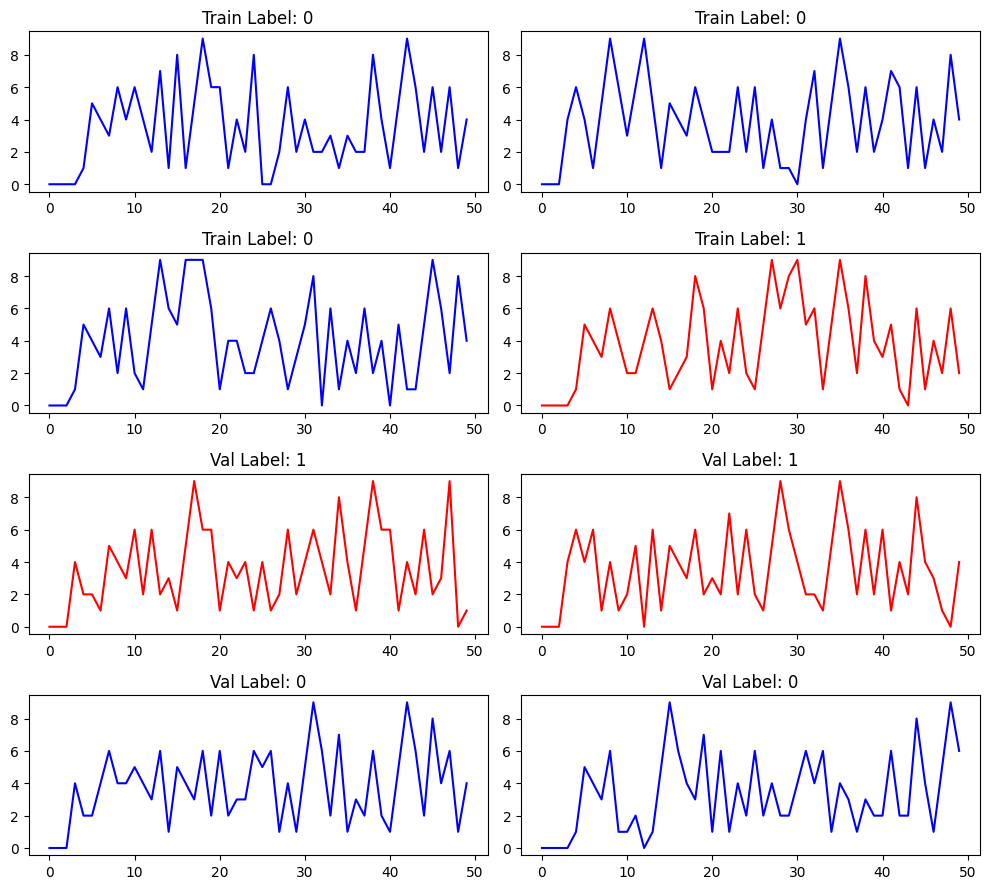

In [231]:
num_examples = 4
rows = 4  # 2 rows for training + 2 rows for validation
cols = 2  # 2x2 grid for training, followed by 2x2 grid for validation

col = ['blue', 'red']

plt.figure(figsize=(10, 9))
# Plotting training data
for i in range(num_examples):
    plt.subplot(rows, cols, i + 1)
    plt.plot(range(X_train.shape[1]), X_train[i], c=col[y_train[i]])
    plt.title(f'Train Label: {y_train[i]}')
    plt.tight_layout()

# Plotting validation data
for i in range(num_examples):
    plt.subplot(rows, cols, i + 1 + num_examples)  # Offset to start below the training plots
    plt.plot(range(X_val.shape[1]), X_val[i], c=col[y_val[i]])
    plt.title(f'Val Label: {y_val[i]}')
    plt.tight_layout()

plt.show()

In [223]:
# Standardization of features
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_val=scaler.transform(X_val)

In [224]:
X_train.shape, X_val.shape

((7080, 50), (489, 50))

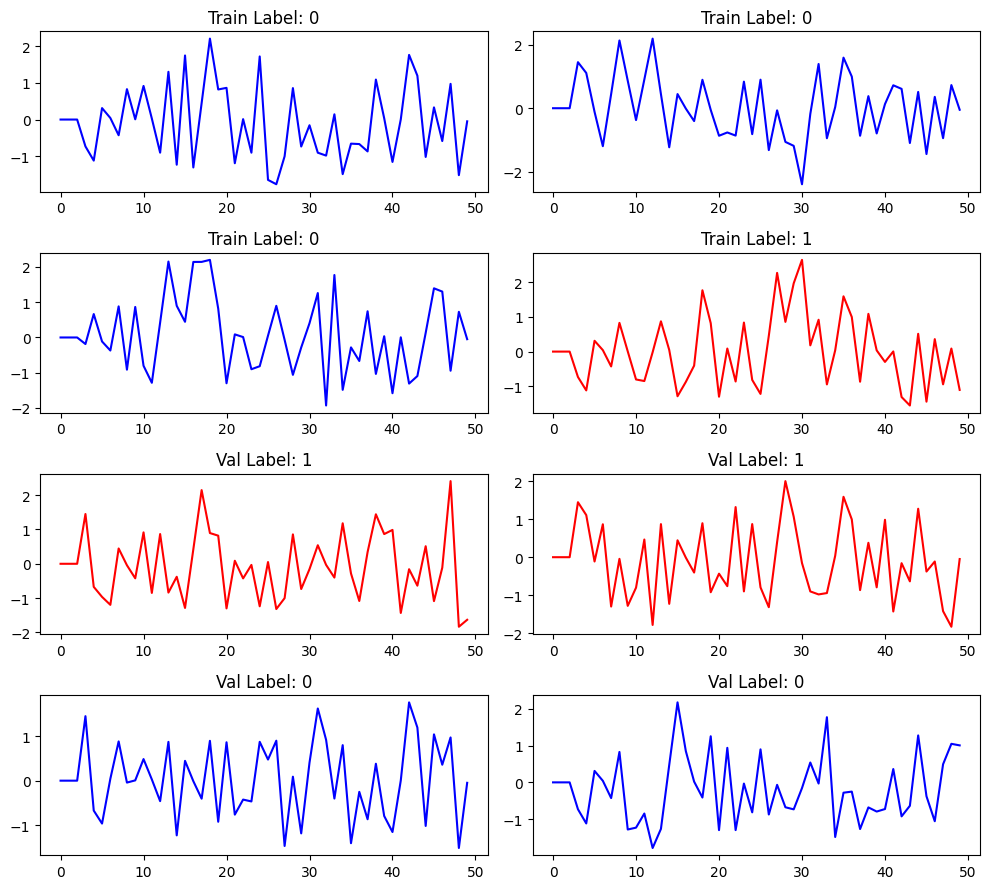

In [228]:
num_examples = 4
rows = 4  # 2 rows for training + 2 rows for validation
cols = 2  # 2x2 grid for training, followed by 2x2 grid for validation

col = ['blue', 'red']

plt.figure(figsize=(10, 9))
# Plotting training data
for i in range(num_examples):
    plt.subplot(rows, cols, i + 1)
    plt.plot(range(X_train.shape[1]), X_train[i], c=col[y_train[i]])
    plt.title(f'Train Label: {y_train[i]}')
    plt.tight_layout()

# Plotting validation data
for i in range(num_examples):
    plt.subplot(rows, cols, i + 1 + num_examples)  # Offset to start below the training plots
    plt.plot(range(X_val.shape[1]), X_val[i], c=col[y_val[i]])
    plt.title(f'Val Label: {y_val[i]}')
    plt.tight_layout()

plt.show()

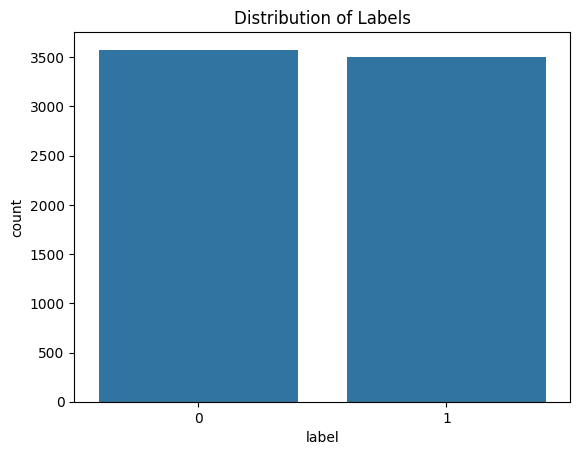

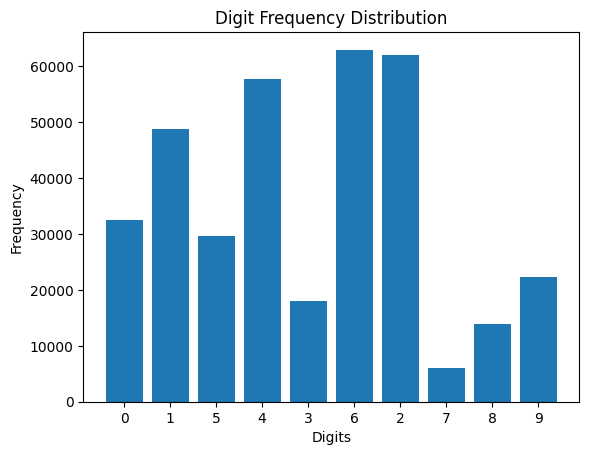

In [104]:
# Countplot of labels
sns.countplot(x='label', data=train_data)
plt.title('Distribution of Labels')
plt.show()

# Counting frequency of each digit (0-9)

all_digits = ''.join(train_data['input_str'].tolist())
digit_counts = Counter(all_digits)
plt.bar(digit_counts.keys(), digit_counts.values())
plt.xlabel('Digits')
plt.ylabel('Frequency')
plt.title('Digit Frequency Distribution')
plt.show()

**CLASSICAL ML MODELS**

In [115]:
# Defining functions for training and evaluation of classical ML models

def evaluate_model_on_training_sizes(X_t,y_t,X_v,y_v,model, percentages=[0.2, 0.4, 0.6, 0.8, 1.0]):
    accuracy_scores = []
    for pct in percentages:
        m=model
        n_train_samples = int(pct * len(X_train))
        X = X_t[:n_train_samples]
        y = y_t[:n_train_samples]
        m.fit(X, y)
        y_val_pred = m.predict(X_v)
        accuracy = accuracy_score(y_v, y_val_pred)
        accuracy_scores.append(accuracy)
        print(f'Evaluation of model trained on {pct*100}% data')
        print(classification_report(y_v,y_val_pred))
        cm = confusion_matrix(y_v, y_val_pred)
        plt.figure(figsize=(4,3))
        sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)
        plt.title(f'Confusion Matrix for {pct*100}% data')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot([pct * 100 for pct in percentages], accuracy_scores, marker='o')
    plt.title('Validation Set Accuracy vs. Percentage of Training Examples')
    plt.xlabel('Percentage of Training Examples')
    plt.ylabel('Validation Set Accuracy')
    plt.xticks([20, 40, 60, 80, 100])
    plt.ylim(0, 1)
    plt.grid()
    plt.show()

    data = {'Percentage of Training Data': [f'{int(pct * 100)}%' for pct in percentages],
            'Validation Accuracy': accuracy_scores}
    table = pd.DataFrame(data)
    print("\nValidation Accuracy vs Percentage of Training Data:\n")
    print(table.to_string(index=False))

**K Nearest Neighbors**

Evaluation of model trained on 20.0% data
              precision    recall  f1-score   support

           0       0.53      0.58      0.56       252
           1       0.51      0.46      0.48       237

    accuracy                           0.52       489
   macro avg       0.52      0.52      0.52       489
weighted avg       0.52      0.52      0.52       489



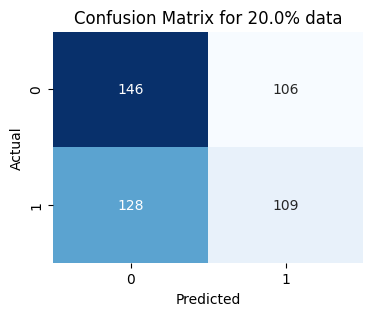

Evaluation of model trained on 40.0% data
              precision    recall  f1-score   support

           0       0.54      0.54      0.54       252
           1       0.51      0.51      0.51       237

    accuracy                           0.53       489
   macro avg       0.53      0.53      0.53       489
weighted avg       0.53      0.53      0.53       489



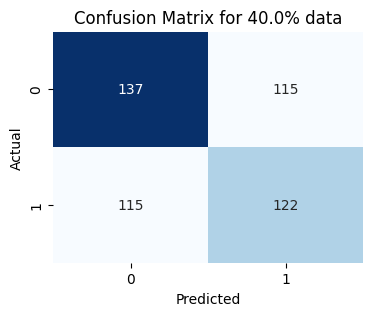

Evaluation of model trained on 60.0% data
              precision    recall  f1-score   support

           0       0.55      0.57      0.56       252
           1       0.53      0.51      0.52       237

    accuracy                           0.54       489
   macro avg       0.54      0.54      0.54       489
weighted avg       0.54      0.54      0.54       489



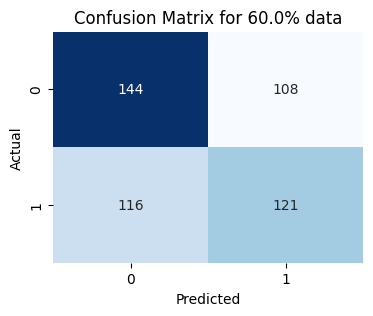

Evaluation of model trained on 80.0% data
              precision    recall  f1-score   support

           0       0.52      0.52      0.52       252
           1       0.49      0.49      0.49       237

    accuracy                           0.50       489
   macro avg       0.50      0.50      0.50       489
weighted avg       0.50      0.50      0.50       489



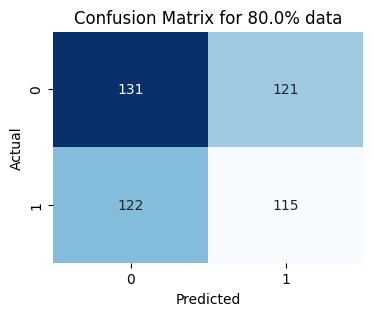

Evaluation of model trained on 100.0% data
              precision    recall  f1-score   support

           0       0.55      0.56      0.56       252
           1       0.52      0.51      0.51       237

    accuracy                           0.54       489
   macro avg       0.54      0.53      0.53       489
weighted avg       0.54      0.54      0.54       489



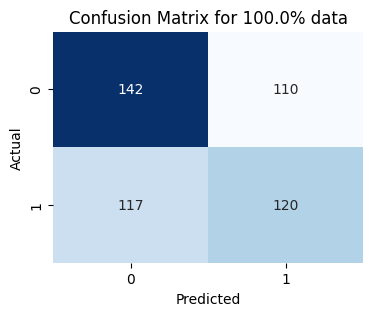

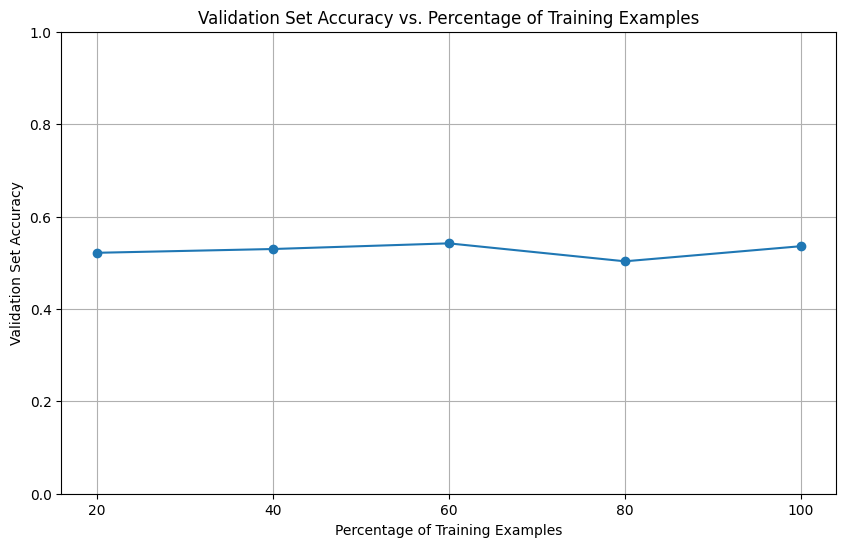


Validation Accuracy vs Percentage of Training Data:

Percentage of Training Data  Validation Accuracy
                        20%             0.521472
                        40%             0.529652
                        60%             0.541922
                        80%             0.503067
                       100%             0.535787


In [116]:
knn_model = KNeighborsClassifier(n_neighbors=5)
evaluate_model_on_training_sizes(X_train, y_train, X_val, y_val, knn_model)

**XGBoost**

Evaluation of model trained on 20.0% data
              precision    recall  f1-score   support

           0       0.57      0.71      0.63       252
           1       0.58      0.44      0.50       237

    accuracy                           0.58       489
   macro avg       0.58      0.57      0.57       489
weighted avg       0.58      0.58      0.57       489



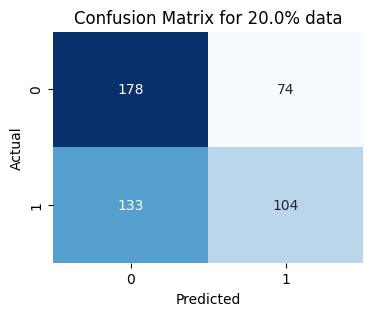

Evaluation of model trained on 40.0% data
              precision    recall  f1-score   support

           0       0.56      0.76      0.65       252
           1       0.60      0.38      0.46       237

    accuracy                           0.57       489
   macro avg       0.58      0.57      0.55       489
weighted avg       0.58      0.57      0.56       489



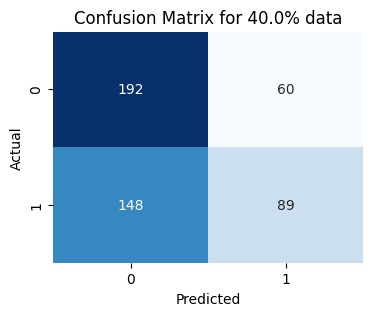

Evaluation of model trained on 60.0% data
              precision    recall  f1-score   support

           0       0.57      0.74      0.64       252
           1       0.59      0.40      0.47       237

    accuracy                           0.57       489
   macro avg       0.58      0.57      0.56       489
weighted avg       0.58      0.57      0.56       489



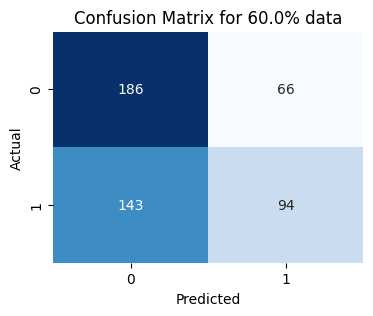

Evaluation of model trained on 80.0% data
              precision    recall  f1-score   support

           0       0.58      0.77      0.66       252
           1       0.63      0.42      0.50       237

    accuracy                           0.60       489
   macro avg       0.60      0.59      0.58       489
weighted avg       0.60      0.60      0.58       489



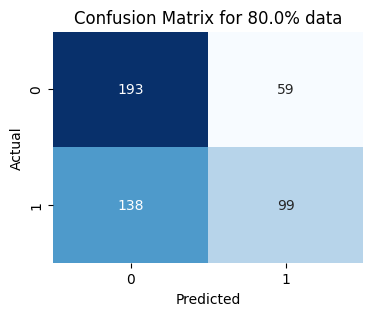

Evaluation of model trained on 100.0% data
              precision    recall  f1-score   support

           0       0.58      0.78      0.66       252
           1       0.63      0.39      0.48       237

    accuracy                           0.59       489
   macro avg       0.60      0.59      0.57       489
weighted avg       0.60      0.59      0.58       489



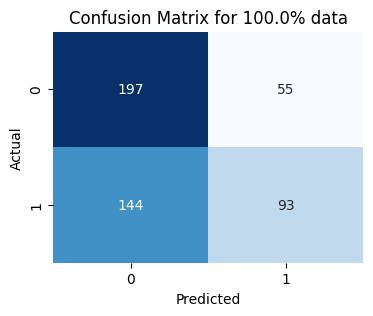

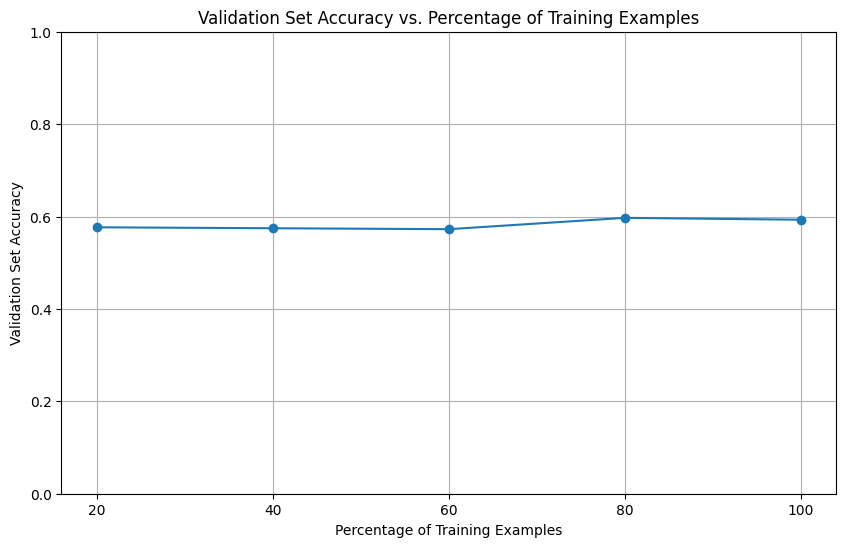


Validation Accuracy vs Percentage of Training Data:

Percentage of Training Data  Validation Accuracy
                        20%             0.576687
                        40%             0.574642
                        60%             0.572597
                        80%             0.597137
                       100%             0.593047


In [117]:
xgb_model = xgb.XGBClassifier(eval_metric='logloss', random_state=42)
evaluate_model_on_training_sizes(X_train, y_train, X_val, y_val, xgb_model)

**Random Forest Classifier**

Evaluation of model trained on 20.0% data
              precision    recall  f1-score   support

           0       0.60      0.60      0.60       252
           1       0.57      0.57      0.57       237

    accuracy                           0.58       489
   macro avg       0.58      0.58      0.58       489
weighted avg       0.58      0.58      0.58       489



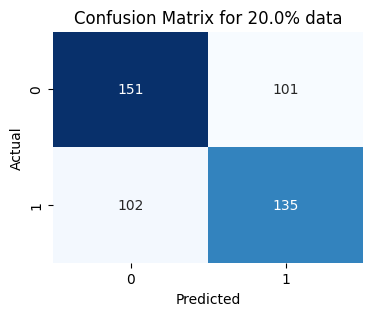

Evaluation of model trained on 40.0% data
              precision    recall  f1-score   support

           0       0.63      0.60      0.61       252
           1       0.59      0.62      0.61       237

    accuracy                           0.61       489
   macro avg       0.61      0.61      0.61       489
weighted avg       0.61      0.61      0.61       489



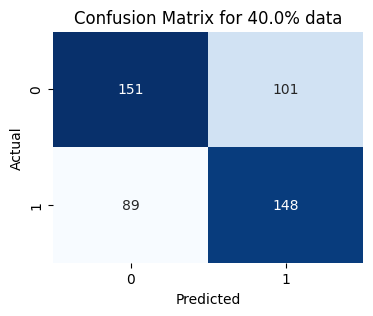

Evaluation of model trained on 60.0% data
              precision    recall  f1-score   support

           0       0.61      0.67      0.64       252
           1       0.61      0.54      0.57       237

    accuracy                           0.61       489
   macro avg       0.61      0.61      0.60       489
weighted avg       0.61      0.61      0.61       489



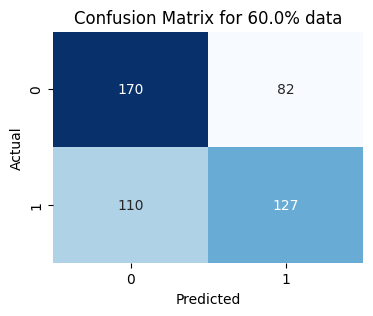

Evaluation of model trained on 80.0% data
              precision    recall  f1-score   support

           0       0.61      0.65      0.63       252
           1       0.60      0.55      0.58       237

    accuracy                           0.61       489
   macro avg       0.60      0.60      0.60       489
weighted avg       0.61      0.61      0.60       489



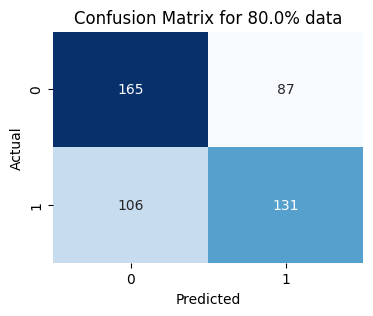

Evaluation of model trained on 100.0% data
              precision    recall  f1-score   support

           0       0.63      0.71      0.67       252
           1       0.64      0.57      0.60       237

    accuracy                           0.64       489
   macro avg       0.64      0.64      0.64       489
weighted avg       0.64      0.64      0.64       489



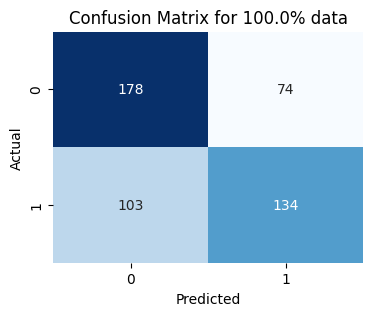

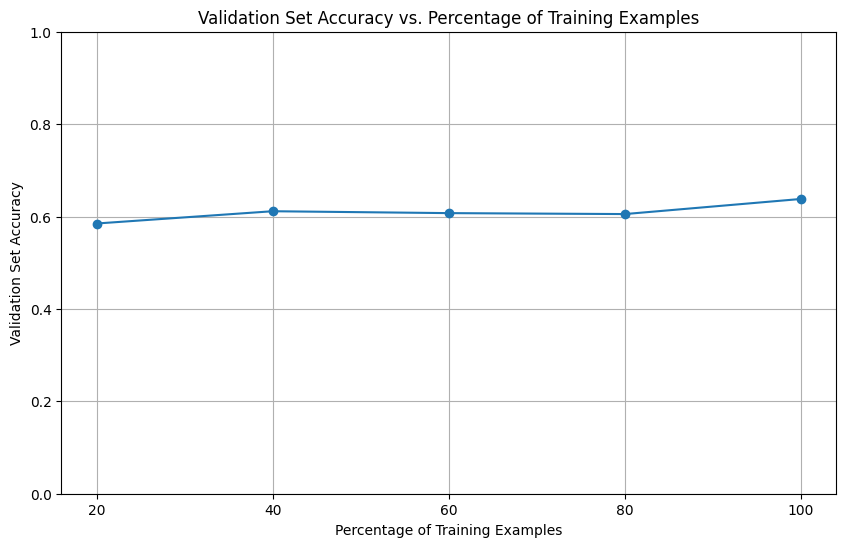


Validation Accuracy vs Percentage of Training Data:

Percentage of Training Data  Validation Accuracy
                        20%             0.584867
                        40%             0.611452
                        60%             0.607362
                        80%             0.605317
                       100%             0.638037


In [118]:
model_rfc = RandomForestClassifier()
evaluate_model_on_training_sizes(X_train,y_train,X_val,y_val,model_rfc)

**Logistic Regression**

Evaluation of model trained on 20.0% data
              precision    recall  f1-score   support

           0       0.59      0.57      0.58       252
           1       0.56      0.57      0.56       237

    accuracy                           0.57       489
   macro avg       0.57      0.57      0.57       489
weighted avg       0.57      0.57      0.57       489



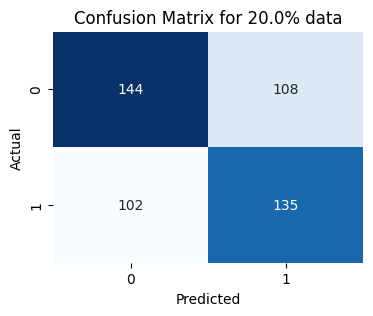

Evaluation of model trained on 40.0% data
              precision    recall  f1-score   support

           0       0.55      0.56      0.56       252
           1       0.53      0.51      0.52       237

    accuracy                           0.54       489
   macro avg       0.54      0.54      0.54       489
weighted avg       0.54      0.54      0.54       489



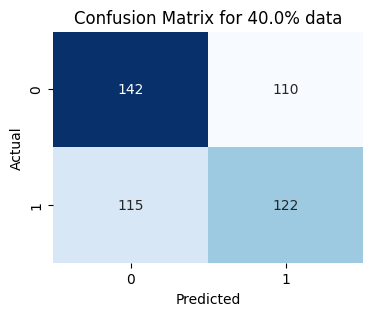

Evaluation of model trained on 60.0% data
              precision    recall  f1-score   support

           0       0.53      0.54      0.54       252
           1       0.50      0.48      0.49       237

    accuracy                           0.51       489
   macro avg       0.51      0.51      0.51       489
weighted avg       0.51      0.51      0.51       489



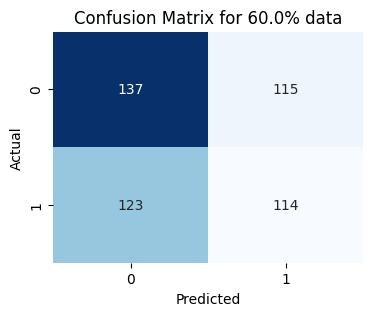

Evaluation of model trained on 80.0% data
              precision    recall  f1-score   support

           0       0.53      0.53      0.53       252
           1       0.50      0.49      0.49       237

    accuracy                           0.51       489
   macro avg       0.51      0.51      0.51       489
weighted avg       0.51      0.51      0.51       489



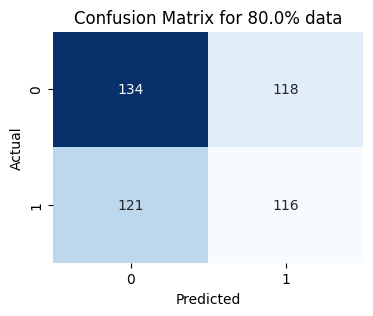

Evaluation of model trained on 100.0% data
              precision    recall  f1-score   support

           0       0.55      0.56      0.56       252
           1       0.52      0.51      0.52       237

    accuracy                           0.54       489
   macro avg       0.54      0.54      0.54       489
weighted avg       0.54      0.54      0.54       489



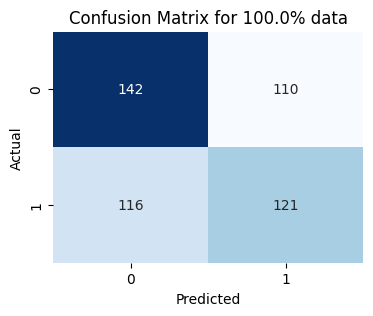

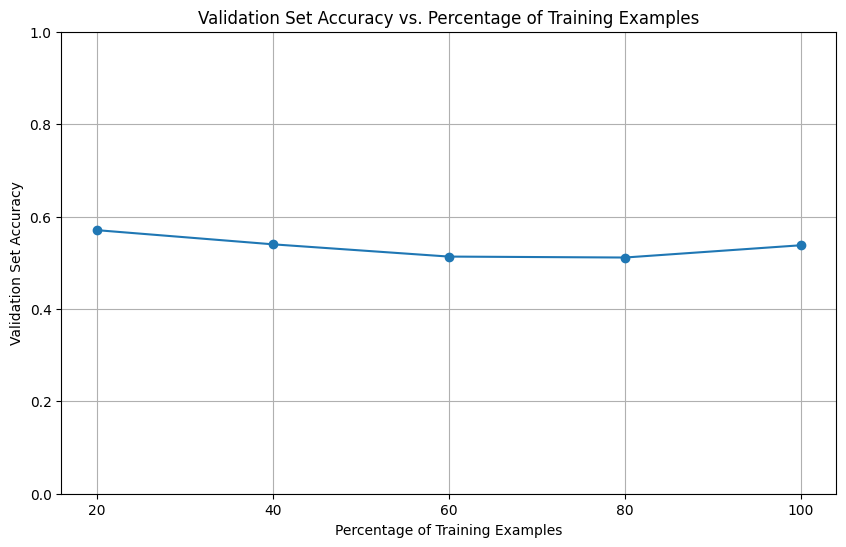


Validation Accuracy vs Percentage of Training Data:

Percentage of Training Data  Validation Accuracy
                        20%             0.570552
                        40%             0.539877
                        60%             0.513292
                        80%             0.511247
                       100%             0.537832


In [119]:
log_reg = LogisticRegression(max_iter=1000)
evaluate_model_on_training_sizes(X_train,y_train,X_val,y_val,log_reg)

**Decision Tree Classifier**

Evaluation of model trained on 20.0% data
              precision    recall  f1-score   support

           0       0.56      0.53      0.54       252
           1       0.52      0.55      0.54       237

    accuracy                           0.54       489
   macro avg       0.54      0.54      0.54       489
weighted avg       0.54      0.54      0.54       489



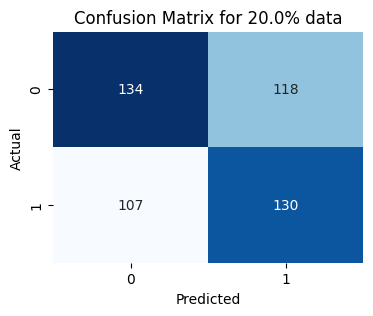

Evaluation of model trained on 40.0% data
              precision    recall  f1-score   support

           0       0.53      0.50      0.51       252
           1       0.50      0.53      0.51       237

    accuracy                           0.51       489
   macro avg       0.51      0.51      0.51       489
weighted avg       0.51      0.51      0.51       489



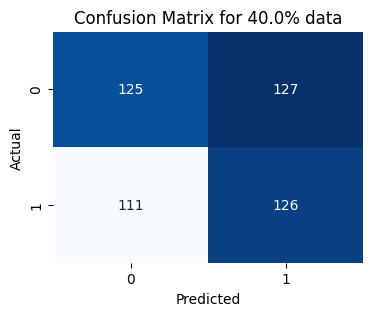

Evaluation of model trained on 60.0% data
              precision    recall  f1-score   support

           0       0.61      0.63      0.62       252
           1       0.59      0.58      0.59       237

    accuracy                           0.60       489
   macro avg       0.60      0.60      0.60       489
weighted avg       0.60      0.60      0.60       489



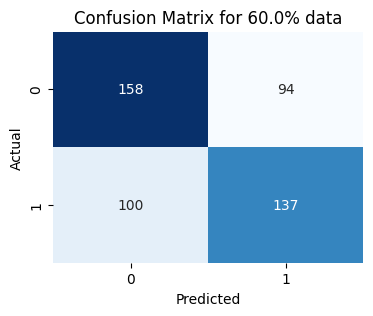

Evaluation of model trained on 80.0% data
              precision    recall  f1-score   support

           0       0.54      0.56      0.55       252
           1       0.51      0.49      0.50       237

    accuracy                           0.53       489
   macro avg       0.52      0.52      0.52       489
weighted avg       0.52      0.53      0.52       489



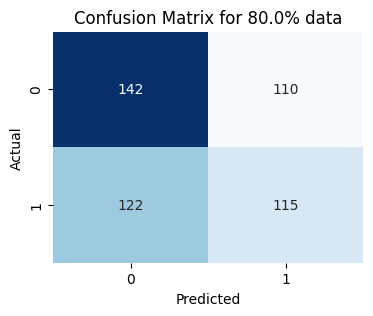

Evaluation of model trained on 100.0% data
              precision    recall  f1-score   support

           0       0.59      0.55      0.57       252
           1       0.55      0.59      0.57       237

    accuracy                           0.57       489
   macro avg       0.57      0.57      0.57       489
weighted avg       0.57      0.57      0.57       489



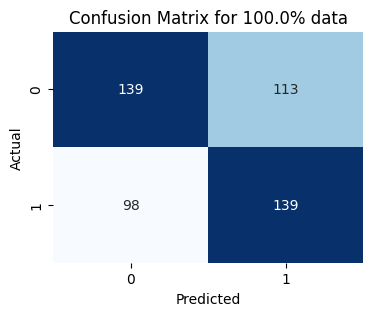

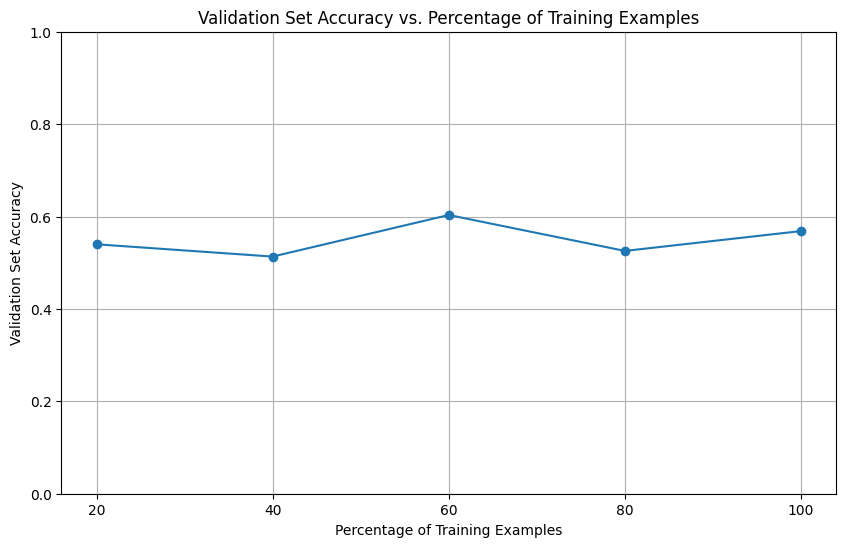


Validation Accuracy vs Percentage of Training Data:

Percentage of Training Data  Validation Accuracy
                        20%             0.539877
                        40%             0.513292
                        60%             0.603272
                        80%             0.525562
                       100%             0.568507


In [120]:
dt_classifier = DecisionTreeClassifier(random_state=42)
evaluate_model_on_training_sizes(X_train,y_train,X_val,y_val,dt_classifier)

**Support Vector Machine (Linear Kernel)**

Evaluation of model trained on 20.0% data
              precision    recall  f1-score   support

           0       0.56      0.58      0.57       252
           1       0.54      0.52      0.53       237

    accuracy                           0.55       489
   macro avg       0.55      0.55      0.55       489
weighted avg       0.55      0.55      0.55       489



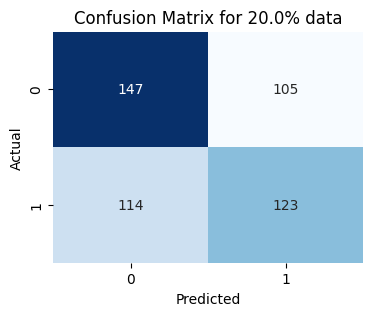

Evaluation of model trained on 40.0% data
              precision    recall  f1-score   support

           0       0.55      0.56      0.55       252
           1       0.52      0.51      0.51       237

    accuracy                           0.53       489
   macro avg       0.53      0.53      0.53       489
weighted avg       0.53      0.53      0.53       489



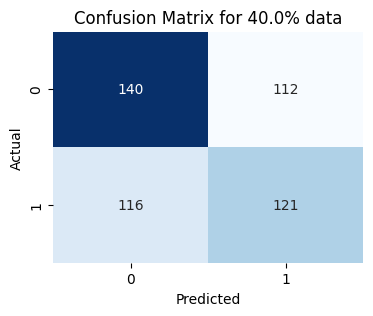

Evaluation of model trained on 60.0% data
              precision    recall  f1-score   support

           0       0.54      0.57      0.55       252
           1       0.51      0.47      0.49       237

    accuracy                           0.52       489
   macro avg       0.52      0.52      0.52       489
weighted avg       0.52      0.52      0.52       489



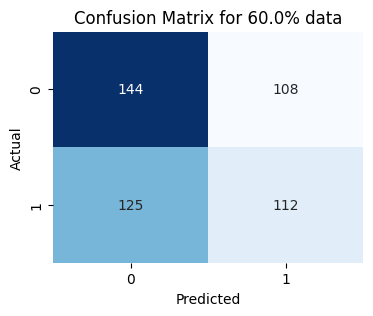

Evaluation of model trained on 80.0% data
              precision    recall  f1-score   support

           0       0.54      0.56      0.55       252
           1       0.51      0.49      0.50       237

    accuracy                           0.52       489
   macro avg       0.52      0.52      0.52       489
weighted avg       0.52      0.52      0.52       489



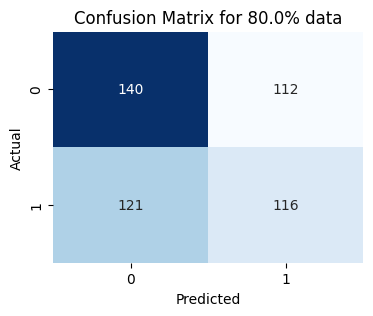

Evaluation of model trained on 100.0% data
              precision    recall  f1-score   support

           0       0.54      0.56      0.55       252
           1       0.51      0.49      0.50       237

    accuracy                           0.53       489
   macro avg       0.52      0.52      0.52       489
weighted avg       0.53      0.53      0.53       489



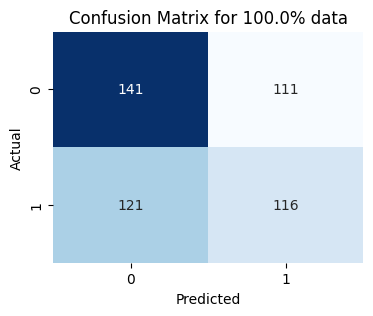

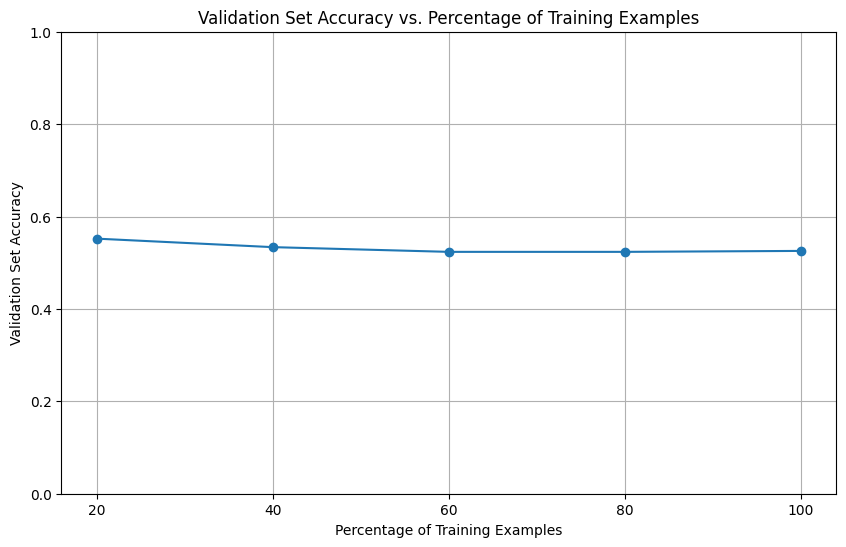


Validation Accuracy vs Percentage of Training Data:

Percentage of Training Data  Validation Accuracy
                        20%             0.552147
                        40%             0.533742
                        60%             0.523517
                        80%             0.523517
                       100%             0.525562


In [121]:
svm_classifier = SVC(kernel='linear', random_state=42)
evaluate_model_on_training_sizes(X_train,y_train,X_val,y_val,svm_classifier)

**Support Vector Machine (Polynomial Kernel)**

Evaluation of model trained on 20.0% data
              precision    recall  f1-score   support

           0       0.55      0.55      0.55       252
           1       0.52      0.53      0.53       237

    accuracy                           0.54       489
   macro avg       0.54      0.54      0.54       489
weighted avg       0.54      0.54      0.54       489



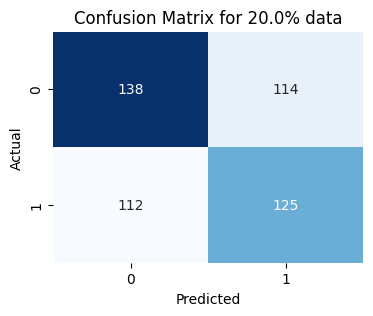

Evaluation of model trained on 40.0% data
              precision    recall  f1-score   support

           0       0.56      0.54      0.55       252
           1       0.53      0.54      0.54       237

    accuracy                           0.54       489
   macro avg       0.54      0.54      0.54       489
weighted avg       0.54      0.54      0.54       489



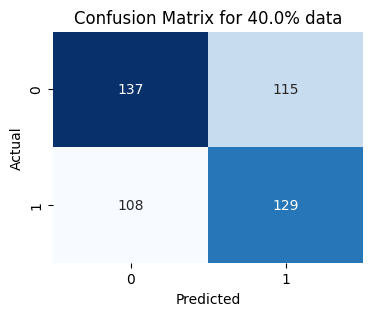

Evaluation of model trained on 60.0% data
              precision    recall  f1-score   support

           0       0.54      0.54      0.54       252
           1       0.51      0.52      0.52       237

    accuracy                           0.53       489
   macro avg       0.53      0.53      0.53       489
weighted avg       0.53      0.53      0.53       489



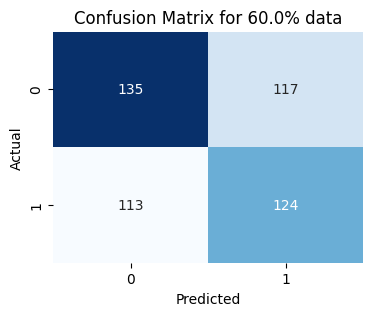

Evaluation of model trained on 80.0% data
              precision    recall  f1-score   support

           0       0.54      0.54      0.54       252
           1       0.51      0.51      0.51       237

    accuracy                           0.53       489
   macro avg       0.53      0.52      0.52       489
weighted avg       0.53      0.53      0.53       489



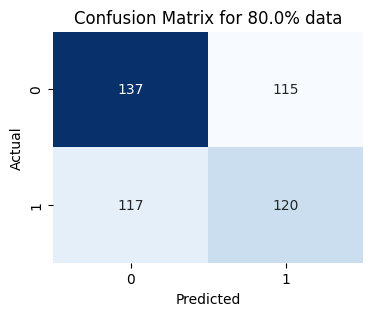

Evaluation of model trained on 100.0% data
              precision    recall  f1-score   support

           0       0.51      0.52      0.52       252
           1       0.48      0.46      0.47       237

    accuracy                           0.49       489
   macro avg       0.49      0.49      0.49       489
weighted avg       0.49      0.49      0.49       489



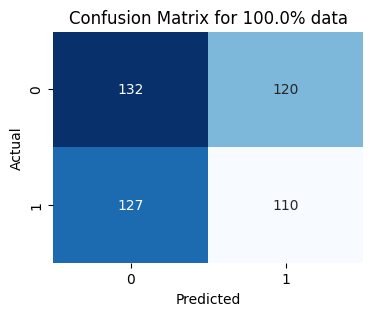

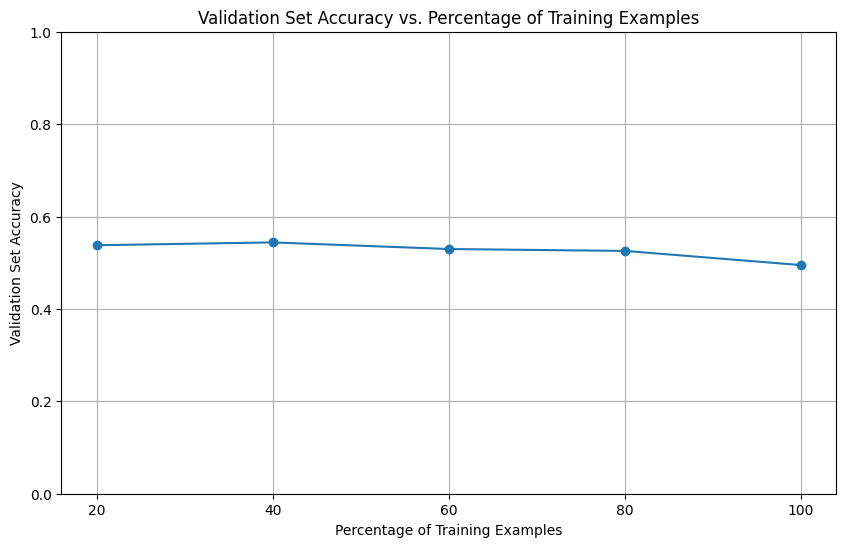


Validation Accuracy vs Percentage of Training Data:

Percentage of Training Data  Validation Accuracy
                        20%             0.537832
                        40%             0.543967
                        60%             0.529652
                        80%             0.525562
                       100%             0.494888


In [122]:
svm_kernelized = SVC(kernel='poly', random_state=42)
evaluate_model_on_training_sizes(X_train,y_train,X_val,y_val,svm_kernelized)

**Support Vector Machine (RBF kernel)**

Evaluation of model trained on 20.0% data
              precision    recall  f1-score   support

           0       0.59      0.58      0.58       252
           1       0.56      0.57      0.57       237

    accuracy                           0.57       489
   macro avg       0.57      0.57      0.57       489
weighted avg       0.58      0.57      0.57       489



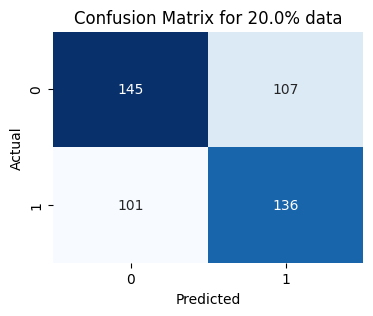

Evaluation of model trained on 40.0% data
              precision    recall  f1-score   support

           0       0.59      0.61      0.60       252
           1       0.57      0.54      0.56       237

    accuracy                           0.58       489
   macro avg       0.58      0.58      0.58       489
weighted avg       0.58      0.58      0.58       489



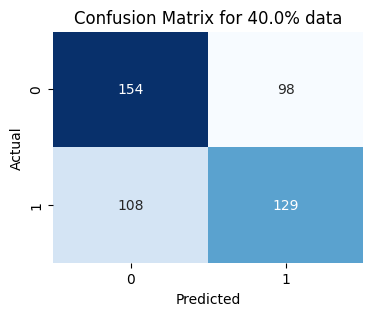

Evaluation of model trained on 60.0% data
              precision    recall  f1-score   support

           0       0.60      0.61      0.61       252
           1       0.58      0.57      0.57       237

    accuracy                           0.59       489
   macro avg       0.59      0.59      0.59       489
weighted avg       0.59      0.59      0.59       489



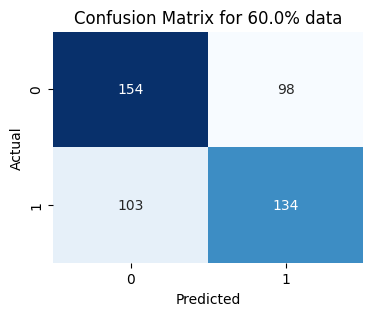

Evaluation of model trained on 80.0% data
              precision    recall  f1-score   support

           0       0.59      0.58      0.59       252
           1       0.56      0.57      0.56       237

    accuracy                           0.57       489
   macro avg       0.57      0.57      0.57       489
weighted avg       0.57      0.57      0.57       489



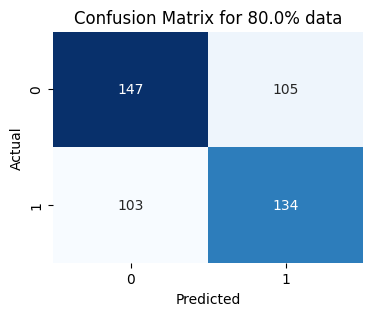

Evaluation of model trained on 100.0% data
              precision    recall  f1-score   support

           0       0.57      0.56      0.57       252
           1       0.54      0.56      0.55       237

    accuracy                           0.56       489
   macro avg       0.56      0.56      0.56       489
weighted avg       0.56      0.56      0.56       489



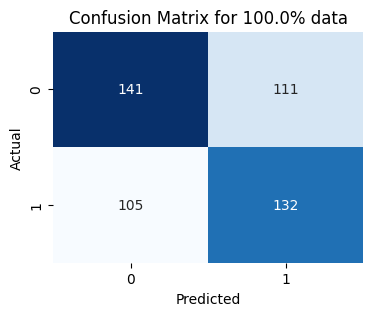

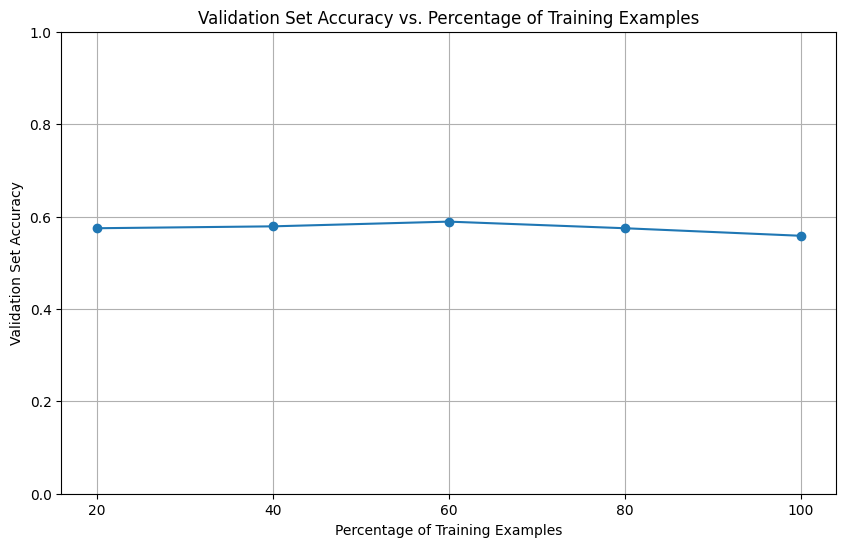


Validation Accuracy vs Percentage of Training Data:

Percentage of Training Data  Validation Accuracy
                        20%             0.574642
                        40%             0.578732
                        60%             0.588957
                        80%             0.574642
                       100%             0.558282


In [162]:
svm_rbf = SVC(kernel='rbf', random_state=42)
evaluate_model_on_training_sizes(X_train,y_train,X_val,y_val,svm_rbf)

**NEURAL NETWORKS**

In [274]:
# Function for training and evaluation of various neural networks, with different amounts of training data

def evaluate_nn_on_training_sizes(X_t, y_t, X_v, y_v, lr, create_model, percentages=[0.2, 0.4, 0.6, 0.8, 1.0], epochs=75, b_s=128):
    accuracy_scores = []
    
    for pct in percentages:
        model = create_model()
        model.compile(optimizer=Adam(learning_rate=lr), loss='binary_crossentropy', metrics=['accuracy'])
        
        # Randomly select a subset of the training data based on the percentage
        if pct == 1:
            X_train_subset, y_train_subset = X_t, y_t
        else:
            X_train_subset, _, y_train_subset, _ = train_test_split(X_t, y_t, train_size=pct, random_state=42)
        
        # Train the model on the random subset
        model.fit(X_train_subset, y_train_subset, epochs=epochs, verbose=0, batch_size=b_s)

        if create_model == create_lstm:
            # Use .keras extension for saving the model
            model_name = f'lstm_trained_on_{int(pct * 100)}_percent_lr={lr}_bs={b_s}.keras'
            model.save(model_name)
        
        # Get predictions on the validation data (binary classification)
        y_val_pred_probs = model.predict(X_v)
        y_val_pred = (y_val_pred_probs > 0.5).astype(int)
        
        # Calculate accuracy on validation data
        accuracy = accuracy_score(y_v, y_val_pred)
        accuracy_scores.append(accuracy)

        # Print evaluation metrics
        print(f'Evaluation of model trained on {pct * 100}% data:')
        print(classification_report(y_v, y_val_pred, zero_division=1))
        
        # Display confusion matrix
        cm = confusion_matrix(y_v, y_val_pred)
        plt.figure(figsize=(4, 3))
        sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)
        plt.title(f'Confusion Matrix for {pct * 100}% data')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

    # Plot validation accuracy against training percentages
    plt.figure(figsize=(10, 6))
    plt.plot([pct * 100 for pct in percentages], accuracy_scores, marker='o')
    plt.title('Validation Set Accuracy vs. Percentage of Training Data')
    plt.xlabel('Percentage of Training Data')
    plt.ylabel('Validation Set Accuracy')

    # Adjust x and y limits and ticks
    plt.xticks([20, 40, 60, 80, 100])  # Custom x-ticks
    
    # Set y-axis limit from 0.4 to 0.8
    plt.ylim(0.4, 0.8)  
    plt.yticks([0.4, 0.5, 0.6, 0.7, 0.8, 0.9], 
               ['40%', '50%', '60%', '70%', '80%', '90%'])  # Custom y-ticks

    plt.grid()
    plt.show()

    # Display a table of accuracy scores
    data = {
        'Percentage of Training Data': [f'{int(pct * 100)}%' for pct in percentages],
        'Validation Accuracy': accuracy_scores
    }
    table = pd.DataFrame(data)
    print("\nValidation Accuracy vs Percentage of Training Data:\n")
    print(table.to_string(index=False))


**Multilayer Perceptron**

In [154]:
def create_mlp():
    model = Sequential()
    model.add(Dense(50, input_shape=(X_train.shape[1],), activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(25, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(10, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(5, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    return model

mlp_model = create_mlp()
mlp_model.compile(optimizer=Adam(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'])
mlp_model.summary()

c:\Users\Akshat\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_103"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_242 (Dense)               │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_140 (Dropout)           │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_243 (Dense)               │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_141 (Dropout)           │ (None, 25)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_244 (Dense)               │ (None, 10)             │           260 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_142 (Dropout)           │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_245 (Dense)               │ (None, 5)              │            55 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_143 (Dropout)           │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_246 (Dense)               │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,146 (16.20 KB)

 Trainable params: 4,146 (16.20 KB)

 Non-trainable params: 0 (0.00 B)

c:\Users\Akshat\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Evaluation of model trained on 20.0% data:
              precision    recall  f1-score   support

           0       0.55      0.37      0.44       252
           1       0.50      0.68      0.58       237

    accuracy                           0.52       489
   macro avg       0.52      0.52      0.51       489
weighted avg       0.53      0.52      0.51       489



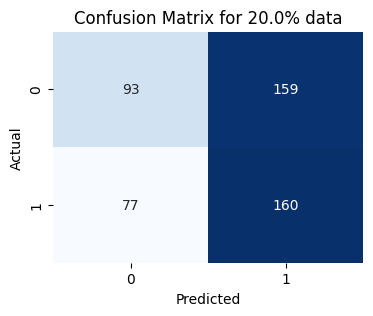

c:\Users\Akshat\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Evaluation of model trained on 40.0% data:
              precision    recall  f1-score   support

           0       0.52      0.34      0.41       252
           1       0.48      0.66      0.56       237

    accuracy                           0.49       489
   macro avg       0.50      0.50      0.48       489
weighted avg       0.50      0.49      0.48       489



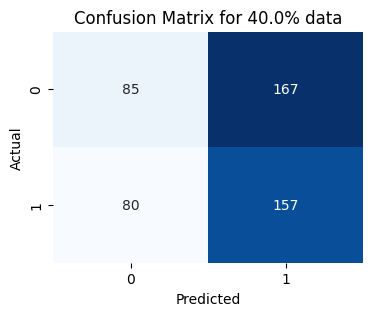

c:\Users\Akshat\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Evaluation of model trained on 60.0% data:
              precision    recall  f1-score   support

           0       0.58      0.39      0.47       252
           1       0.52      0.70      0.59       237

    accuracy                           0.54       489
   macro avg       0.55      0.54      0.53       489
weighted avg       0.55      0.54      0.53       489



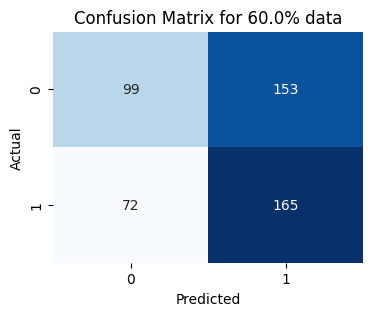

c:\Users\Akshat\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Evaluation of model trained on 80.0% data:
              precision    recall  f1-score   support

           0       0.55      0.29      0.38       252
           1       0.50      0.74      0.60       237

    accuracy                           0.51       489
   macro avg       0.52      0.52      0.49       489
weighted avg       0.52      0.51      0.49       489



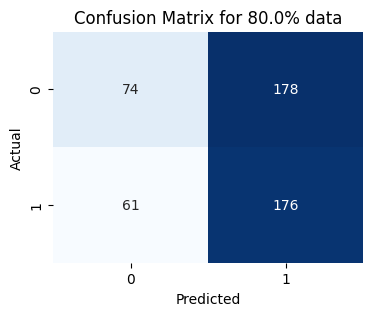

c:\Users\Akshat\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Evaluation of model trained on 100.0% data:
              precision    recall  f1-score   support

           0       0.56      0.57      0.56       252
           1       0.53      0.52      0.52       237

    accuracy                           0.54       489
   macro avg       0.54      0.54      0.54       489
weighted avg       0.54      0.54      0.54       489



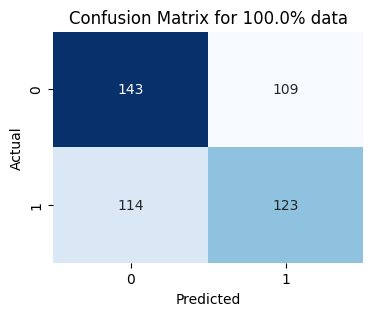

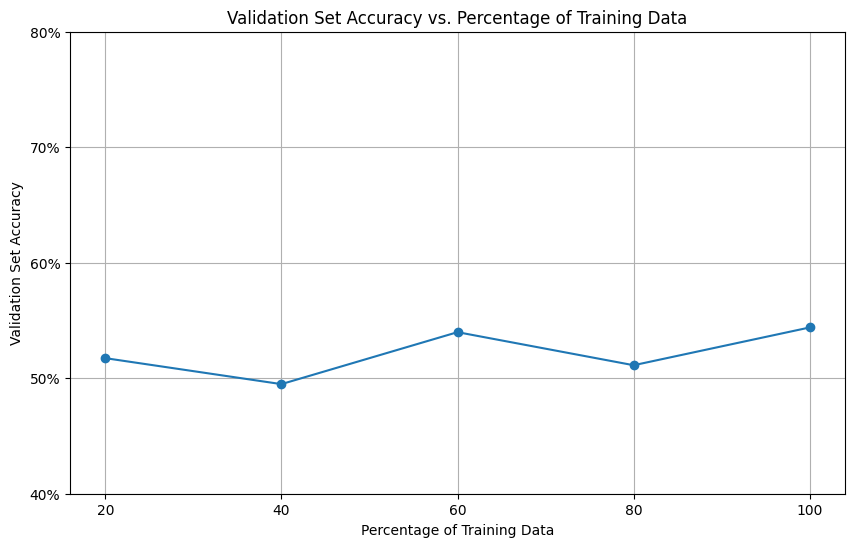


Validation Accuracy vs Percentage of Training Data:

Percentage of Training Data  Validation Accuracy
                        20%             0.517382
                        40%             0.494888
                        60%             0.539877
                        80%             0.511247
                       100%             0.543967


In [160]:
evaluate_nn_on_training_sizes(X_train, y_train, X_val, y_val, 0.001, create_mlp,epochs=10)

**Fully Convolutional Network**

In [127]:
def create_fcn():
    model = Sequential()
    model.add(Conv1D(16, kernel_size=3, padding='same', input_shape=(X_train.shape[1], 1)))  # 16 filters
    model.add(BatchNormalization())
    model.add(ReLU())
    
    model.add(Conv1D(32, kernel_size=3, padding='same'))  # 32 filters
    model.add(BatchNormalization())
    model.add(ReLU())
    
    model.add(Conv1D(16, kernel_size=3, padding='same'))  # 16 filters
    model.add(BatchNormalization())
    model.add(ReLU())
    
    model.add(GlobalAveragePooling1D())
    model.add(Dense(1, activation='sigmoid'))  # Output layer
    return model

fcn_model = create_fcn()
fcn_model.compile(optimizer=Adam(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'])
fcn_model.summary()

c:\Users\Akshat\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_54"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_45 (Conv1D)              │ (None, 50, 16)         │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_45          │ (None, 50, 16)         │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_45 (ReLU)                 │ (None, 50, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_46 (Conv1D)              │ (None, 50, 32)         │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_46          │ (None, 50, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_46 (ReLU)                 │ (None, 50, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_47 (Conv1D)              │ (None, 50, 16)         │         1,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_47          │ (None, 50, 16)         │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_47 (ReLU)                 │ (None, 50, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_15     │ (None, 16)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_162 (Dense)               │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,457 (13.50 KB)

 Trainable params: 3,329 (13.00 KB)

 Non-trainable params: 128 (512.00 B)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Evaluation of model trained on 20.0% data:
              precision    recall  f1-score   support

           0       0.52      1.00      0.68       252
           1       1.00      0.02      0.04       237

    accuracy                           0.53       489
   macro avg       0.76      0.51      0.36       489
weighted avg       0.75      0.53      0.37       489



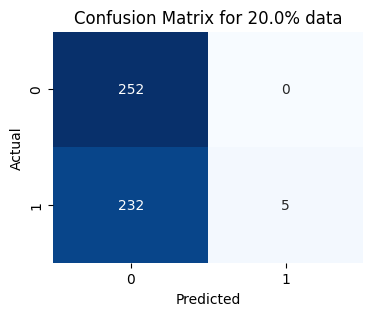

c:\Users\Akshat\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Evaluation of model trained on 40.0% data:
              precision    recall  f1-score   support

           0       0.70      0.25      0.37       252
           1       0.53      0.89      0.66       237

    accuracy                           0.56       489
   macro avg       0.62      0.57      0.52       489
weighted avg       0.62      0.56      0.51       489



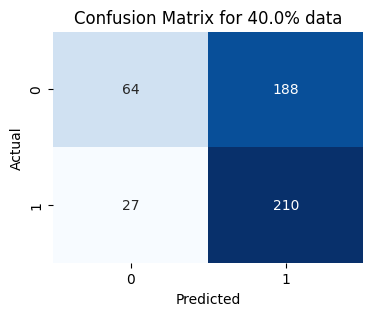

c:\Users\Akshat\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Evaluation of model trained on 60.0% data:
              precision    recall  f1-score   support

           0       0.94      0.07      0.13       252
           1       0.50      1.00      0.67       237

    accuracy                           0.52       489
   macro avg       0.72      0.53      0.40       489
weighted avg       0.73      0.52      0.39       489



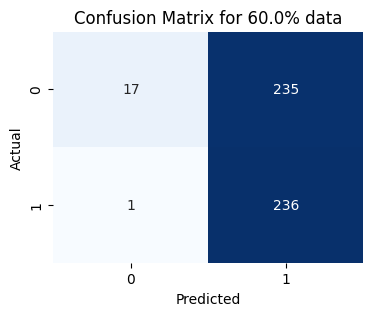

c:\Users\Akshat\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Evaluation of model trained on 80.0% data:
              precision    recall  f1-score   support

           0       0.66      0.82      0.73       252
           1       0.74      0.56      0.64       237

    accuracy                           0.69       489
   macro avg       0.70      0.69      0.68       489
weighted avg       0.70      0.69      0.69       489



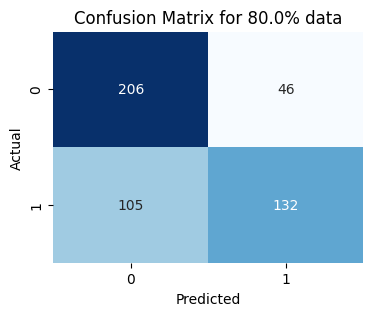

c:\Users\Akshat\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Evaluation of model trained on 100.0% data:
              precision    recall  f1-score   support

           0       0.57      0.98      0.73       252
           1       0.93      0.22      0.36       237

    accuracy                           0.62       489
   macro avg       0.75      0.60      0.54       489
weighted avg       0.75      0.62      0.55       489



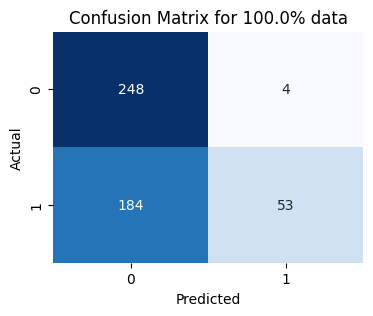

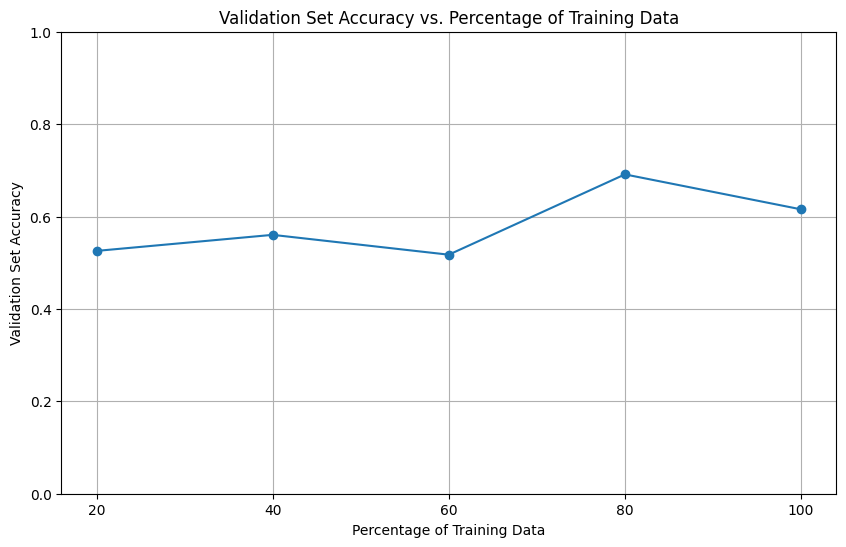


Validation Accuracy vs Percentage of Training Data:

Percentage of Training Data  Validation Accuracy
                        20%             0.525562
                        40%             0.560327
                        60%             0.517382
                        80%             0.691207
                       100%             0.615542


In [129]:
evaluate_nn_on_training_sizes(X_train, y_train, X_val, y_val, 0.01, create_fcn, epochs=100)

**LSTM**

In [275]:
def create_lstm():
    lstm=Sequential()
    lstm.add(LSTM(32, input_shape=(X_train.shape[1],1)))
    lstm.add(Dense(1, activation='sigmoid'))
    return lstm

lstm_model = create_lstm()
lstm_model.compile(optimizer=Adam(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'])
lstm_model.summary()

Model: "sequential_265"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_186 (LSTM)                 │ (None, 32)             │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_480 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,385 (17.13 KB)

 Trainable params: 4,385 (17.13 KB)

 Non-trainable params: 0 (0.00 B)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Evaluation of model trained on 20.0% data:
              precision    recall  f1-score   support

           0       0.55      0.40      0.47       252
           1       0.50      0.65      0.57       237

    accuracy                           0.52       489
   macro avg       0.53      0.53      0.52       489
weighted avg       0.53      0.52      0.51       489



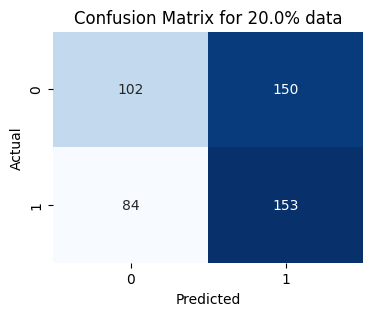

c:\Users\Akshat\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Evaluation of model trained on 40.0% data:
              precision    recall  f1-score   support

           0       0.61      0.75      0.67       252
           1       0.65      0.50      0.57       237

    accuracy                           0.63       489
   macro avg       0.63      0.62      0.62       489
weighted avg       0.63      0.63      0.62       489



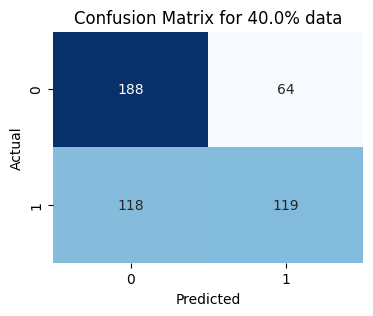

c:\Users\Akshat\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
Evaluation of model trained on 60.0% data:
              precision    recall  f1-score   support

           0       0.64      0.62      0.63       252
           1       0.61      0.64      0.62       237

    accuracy                           0.63       489
   macro avg       0.63      0.63      0.63       489
weighted avg       0.63      0.63      0.63       489



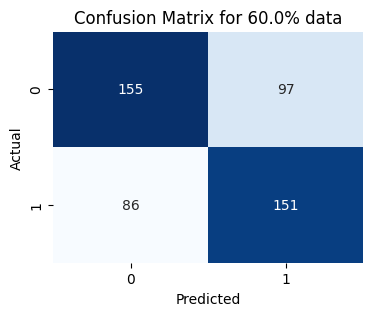

c:\Users\Akshat\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Evaluation of model trained on 80.0% data:
              precision    recall  f1-score   support

           0       0.64      0.63      0.64       252
           1       0.61      0.63      0.62       237

    accuracy                           0.63       489
   macro avg       0.63      0.63      0.63       489
weighted avg       0.63      0.63      0.63       489



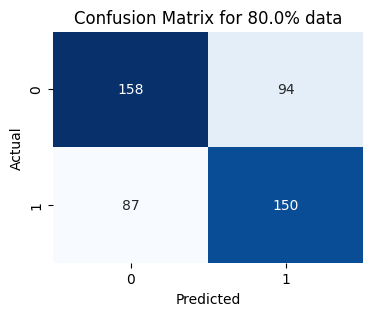

c:\Users\Akshat\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Evaluation of model trained on 100.0% data:
              precision    recall  f1-score   support

           0       0.69      0.46      0.55       252
           1       0.58      0.78      0.67       237

    accuracy                           0.62       489
   macro avg       0.64      0.62      0.61       489
weighted avg       0.64      0.62      0.61       489



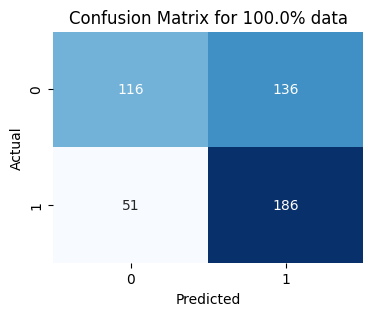

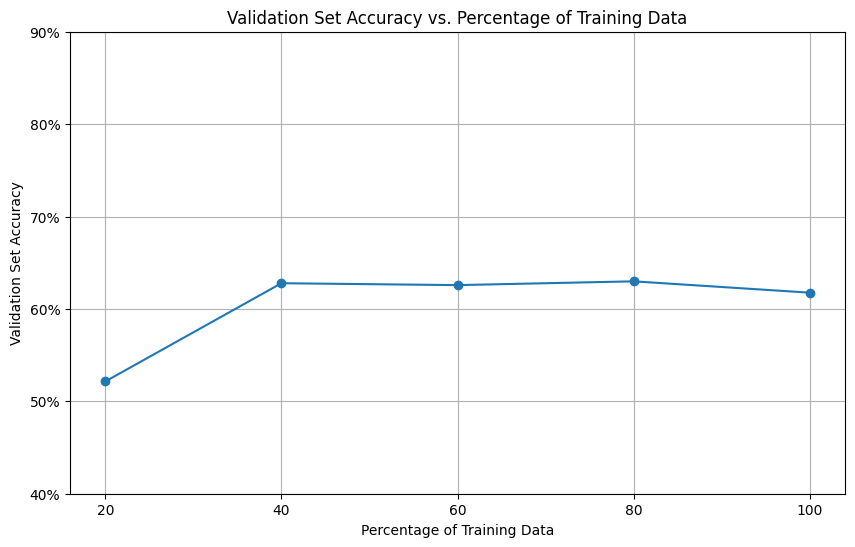


Validation Accuracy vs Percentage of Training Data:

Percentage of Training Data  Validation Accuracy
                        20%             0.521472
                        40%             0.627812
                        60%             0.625767
                        80%             0.629857
                       100%             0.617587


In [276]:
evaluate_nn_on_training_sizes(X_train, y_train, X_val, y_val, 0.001, create_lstm, epochs=75)

c:\Users\Akshat\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
Evaluation of model trained on 20.0% data:
              precision    recall  f1-score   support

           0       0.60      0.60      0.60       252
           1       0.57      0.57      0.57       237

    accuracy                           0.59       489
   macro avg       0.59      0.59      0.59       489
weighted avg       0.59      0.59      0.59       489



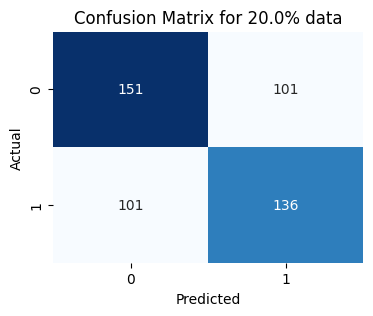

c:\Users\Akshat\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Evaluation of model trained on 40.0% data:
              precision    recall  f1-score   support

           0       0.66      0.65      0.65       252
           1       0.63      0.65      0.64       237

    accuracy                           0.65       489
   macro avg       0.65      0.65      0.65       489
weighted avg       0.65      0.65      0.65       489



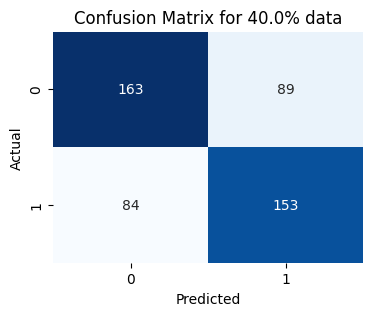

c:\Users\Akshat\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
Evaluation of model trained on 60.0% data:
              precision    recall  f1-score   support

           0       0.65      0.75      0.69       252
           1       0.68      0.57      0.62       237

    accuracy                           0.66       489
   macro avg       0.66      0.66      0.66       489
weighted avg       0.66      0.66      0.66       489



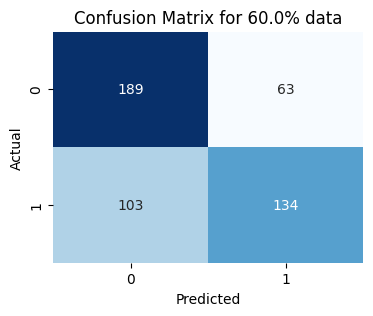

c:\Users\Akshat\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
Evaluation of model trained on 80.0% data:
              precision    recall  f1-score   support

           0       0.73      0.72      0.73       252
           1       0.71      0.72      0.71       237

    accuracy                           0.72       489
   macro avg       0.72      0.72      0.72       489
weighted avg       0.72      0.72      0.72       489



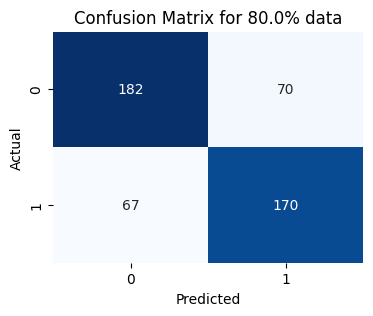

c:\Users\Akshat\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Evaluation of model trained on 100.0% data:
              precision    recall  f1-score   support

           0       0.75      0.76      0.75       252
           1       0.74      0.73      0.73       237

    accuracy                           0.74       489
   macro avg       0.74      0.74      0.74       489
weighted avg       0.74      0.74      0.74       489



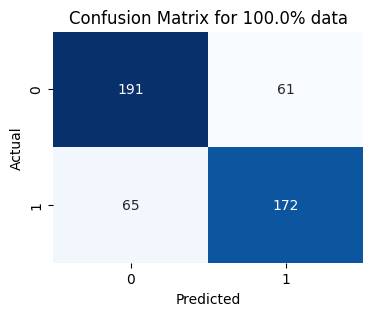

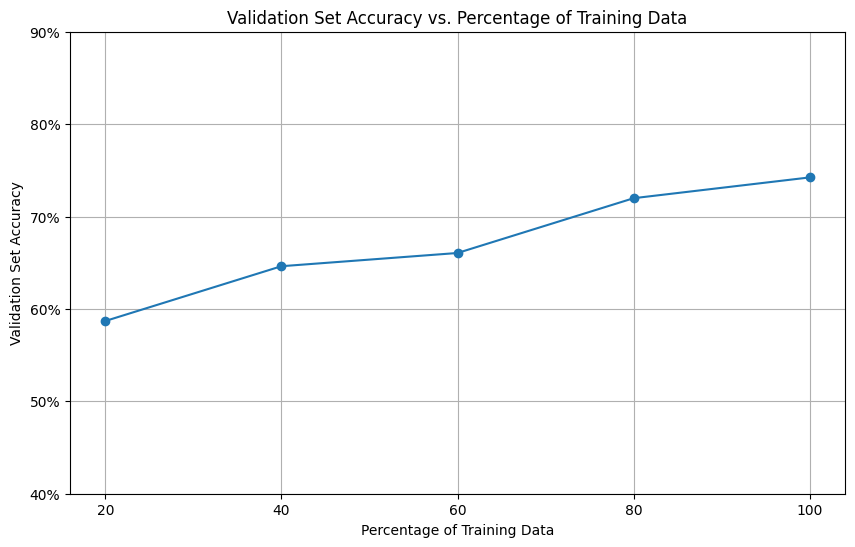


Validation Accuracy vs Percentage of Training Data:

Percentage of Training Data  Validation Accuracy
                        20%             0.586912
                        40%             0.646217
                        60%             0.660532
                        80%             0.719836
                       100%             0.742331


In [277]:
evaluate_nn_on_training_sizes(X_train, y_train, X_val, y_val, 0.005, create_lstm, epochs=75)

c:\Users\Akshat\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
Evaluation of model trained on 20.0% data:
              precision    recall  f1-score   support

           0       0.59      0.71      0.64       252
           1       0.61      0.48      0.54       237

    accuracy                           0.60       489
   macro avg       0.60      0.59      0.59       489
weighted avg       0.60      0.60      0.59       489



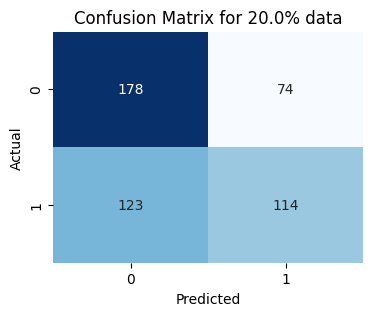

c:\Users\Akshat\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
Evaluation of model trained on 40.0% data:
              precision    recall  f1-score   support

           0       0.61      0.77      0.68       252
           1       0.66      0.49      0.56       237

    accuracy                           0.63       489
   macro avg       0.64      0.63      0.62       489
weighted avg       0.64      0.63      0.62       489



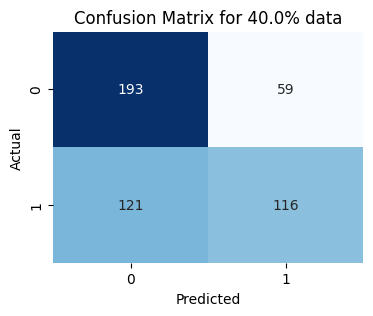

c:\Users\Akshat\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
Evaluation of model trained on 60.0% data:
              precision    recall  f1-score   support

           0       0.68      0.74      0.71       252
           1       0.69      0.62      0.66       237

    accuracy                           0.68       489
   macro avg       0.68      0.68      0.68       489
weighted avg       0.68      0.68      0.68       489



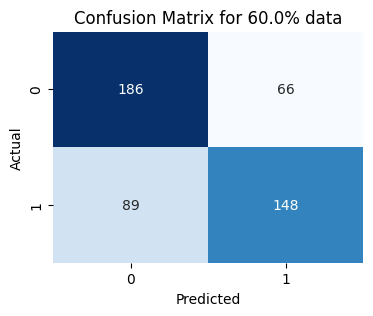

c:\Users\Akshat\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
Evaluation of model trained on 80.0% data:
              precision    recall  f1-score   support

           0       0.69      0.74      0.71       252
           1       0.70      0.64      0.67       237

    accuracy                           0.69       489
   macro avg       0.69      0.69      0.69       489
weighted avg       0.69      0.69      0.69       489



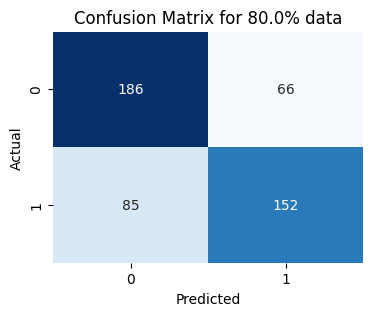

c:\Users\Akshat\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
Evaluation of model trained on 100.0% data:
              precision    recall  f1-score   support

           0       0.79      0.73      0.76       252
           1       0.73      0.79      0.76       237

    accuracy                           0.76       489
   macro avg       0.76      0.76      0.76       489
weighted avg       0.76      0.76      0.76       489



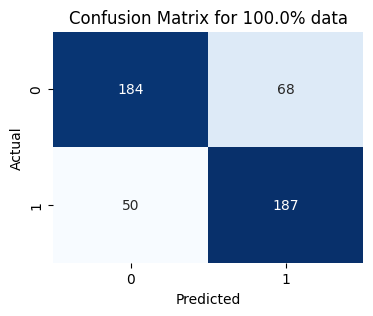

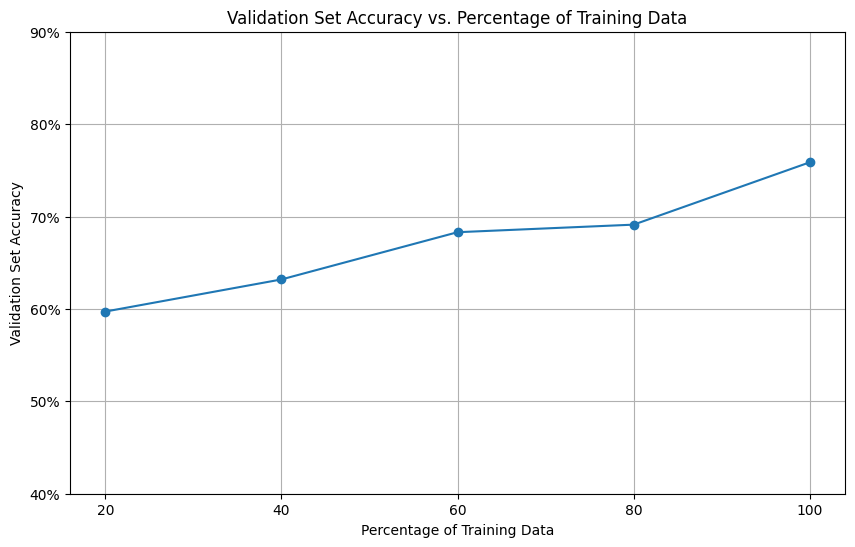


Validation Accuracy vs Percentage of Training Data:

Percentage of Training Data  Validation Accuracy
                        20%             0.597137
                        40%             0.631902
                        60%             0.683027
                        80%             0.691207
                       100%             0.758691


In [278]:
evaluate_nn_on_training_sizes(X_train, y_train, X_val, y_val, 0.010, create_lstm, epochs=75)

c:\Users\Akshat\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Evaluation of model trained on 20.0% data:
              precision    recall  f1-score   support

           0       0.52      0.98      0.68       252
           1       0.57      0.03      0.06       237

    accuracy                           0.52       489
   macro avg       0.54      0.50      0.37       489
weighted avg       0.54      0.52      0.38       489



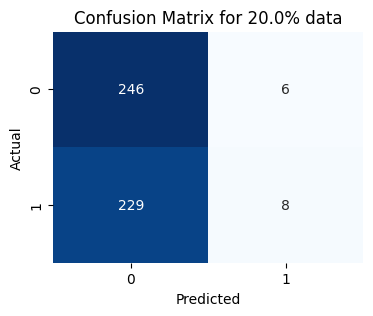

c:\Users\Akshat\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Evaluation of model trained on 40.0% data:
              precision    recall  f1-score   support

           0       0.52      1.00      0.69       252
           1       1.00      0.03      0.07       237

    accuracy                           0.53       489
   macro avg       0.76      0.52      0.38       489
weighted avg       0.75      0.53      0.39       489



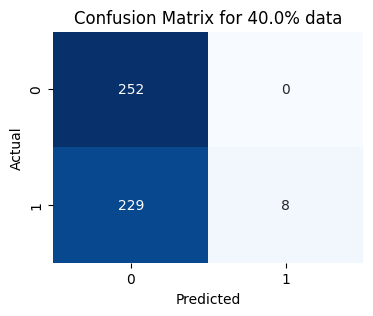

c:\Users\Akshat\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
Evaluation of model trained on 60.0% data:
              precision    recall  f1-score   support

           0       0.51      0.51      0.51       252
           1       0.48      0.48      0.48       237

    accuracy                           0.50       489
   macro avg       0.50      0.50      0.50       489
weighted avg       0.50      0.50      0.50       489



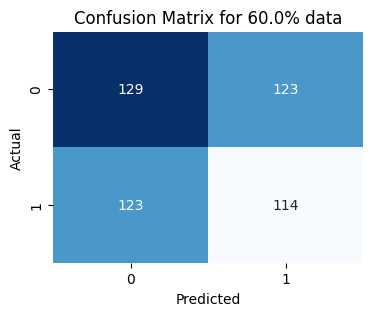

c:\Users\Akshat\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
Evaluation of model trained on 80.0% data:
              precision    recall  f1-score   support

           0       0.54      0.57      0.55       252
           1       0.51      0.48      0.49       237

    accuracy                           0.53       489
   macro avg       0.52      0.52      0.52       489
weighted avg       0.52      0.53      0.52       489



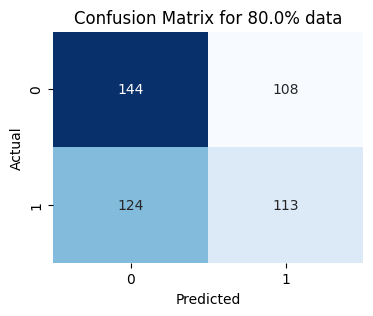

c:\Users\Akshat\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
Evaluation of model trained on 100.0% data:
              precision    recall  f1-score   support

           0       0.64      0.19      0.29       252
           1       0.51      0.89      0.65       237

    accuracy                           0.53       489
   macro avg       0.57      0.54      0.47       489
weighted avg       0.58      0.53      0.46       489



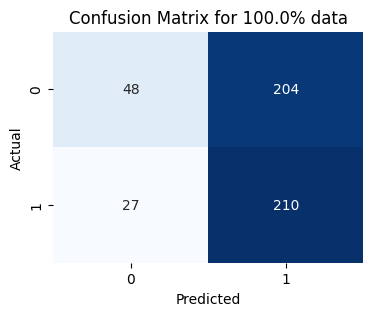

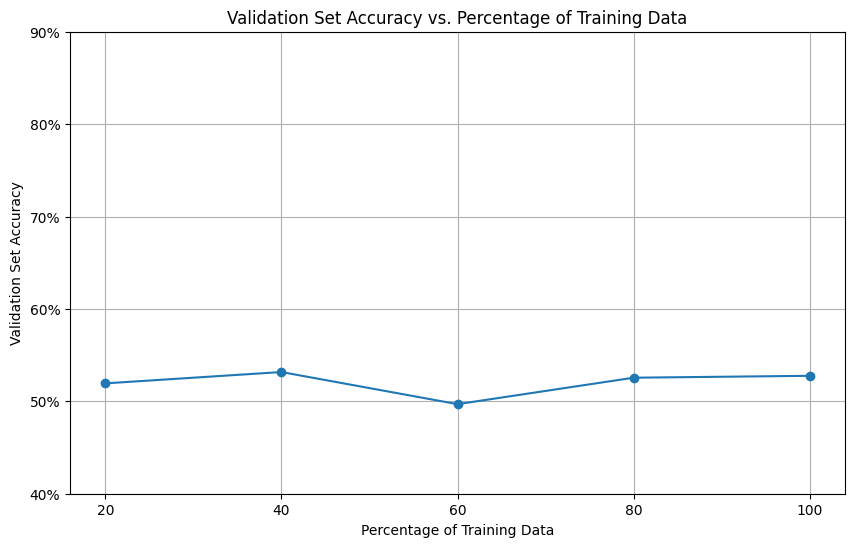


Validation Accuracy vs Percentage of Training Data:

Percentage of Training Data  Validation Accuracy
                        20%             0.519427
                        40%             0.531697
                        60%             0.496933
                        80%             0.525562
                       100%             0.527607


In [279]:
evaluate_nn_on_training_sizes(X_train, y_train, X_val, y_val, 0.050, create_lstm, epochs=75)

c:\Users\Akshat\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
Evaluation of model trained on 20.0% data:
              precision    recall  f1-score   support

           0       0.21      0.01      0.02       252
           1       0.48      0.95      0.63       237

    accuracy                           0.47       489
   macro avg       0.35      0.48      0.33       489
weighted avg       0.34      0.47      0.32       489



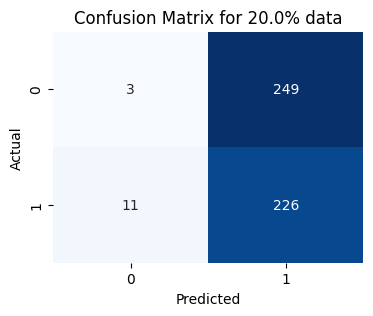

c:\Users\Akshat\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
Evaluation of model trained on 40.0% data:
              precision    recall  f1-score   support

           0       0.40      0.01      0.02       252
           1       0.48      0.99      0.65       237

    accuracy                           0.48       489
   macro avg       0.44      0.50      0.33       489
weighted avg       0.44      0.48      0.32       489



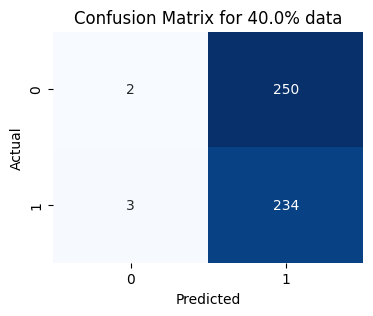

c:\Users\Akshat\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
Evaluation of model trained on 60.0% data:
              precision    recall  f1-score   support

           0       0.52      1.00      0.68       252
           1       1.00      0.02      0.03       237

    accuracy                           0.52       489
   macro avg       0.76      0.51      0.36       489
weighted avg       0.75      0.52      0.37       489



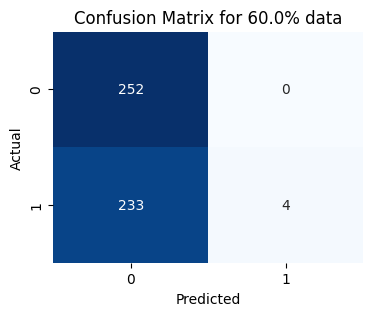

c:\Users\Akshat\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
Evaluation of model trained on 80.0% data:
              precision    recall  f1-score   support

           0       0.38      0.02      0.04       252
           1       0.48      0.96      0.64       237

    accuracy                           0.48       489
   macro avg       0.43      0.49      0.34       489
weighted avg       0.43      0.48      0.33       489



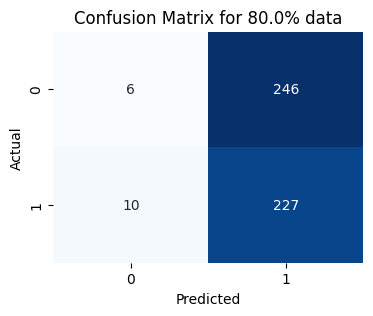

c:\Users\Akshat\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Evaluation of model trained on 100.0% data:
              precision    recall  f1-score   support

           0       0.38      0.02      0.04       252
           1       0.48      0.96      0.64       237

    accuracy                           0.48       489
   macro avg       0.43      0.49      0.34       489
weighted avg       0.43      0.48      0.33       489



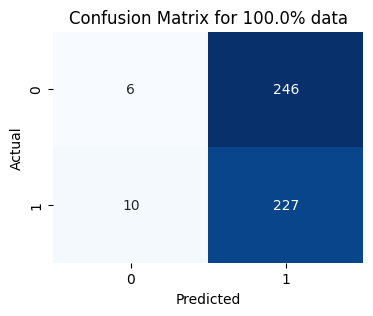

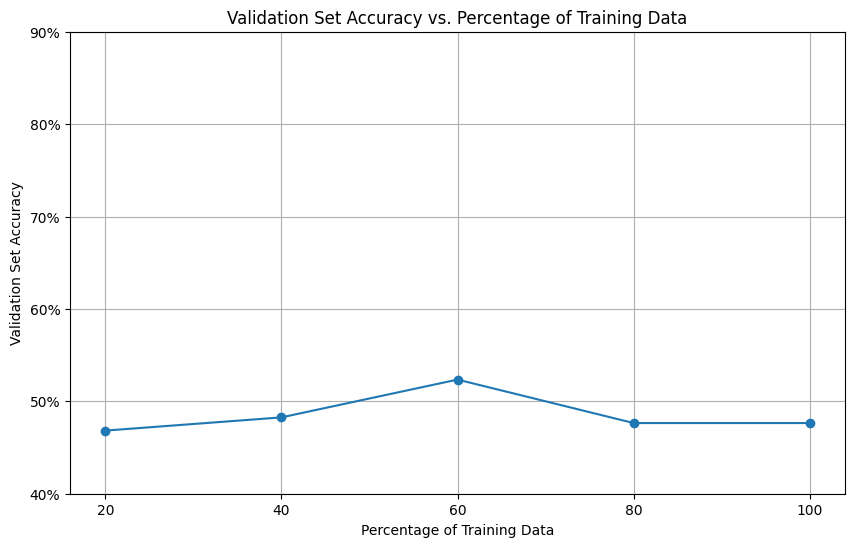


Validation Accuracy vs Percentage of Training Data:

Percentage of Training Data  Validation Accuracy
                        20%             0.468303
                        40%             0.482618
                        60%             0.523517
                        80%             0.476483
                       100%             0.476483


In [280]:
evaluate_nn_on_training_sizes(X_train, y_train, X_val, y_val, 0.100, create_lstm, epochs=75)

c:\Users\Akshat\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
Evaluation of model trained on 20.0% data:
              precision    recall  f1-score   support

           0       0.60      0.69      0.64       252
           1       0.60      0.50      0.55       237

    accuracy                           0.60       489
   macro avg       0.60      0.60      0.59       489
weighted avg       0.60      0.60      0.60       489



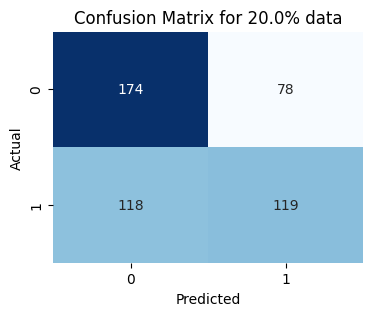

c:\Users\Akshat\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Evaluation of model trained on 40.0% data:
              precision    recall  f1-score   support

           0       0.67      0.73      0.70       252
           1       0.69      0.62      0.65       237

    accuracy                           0.68       489
   macro avg       0.68      0.68      0.68       489
weighted avg       0.68      0.68      0.68       489



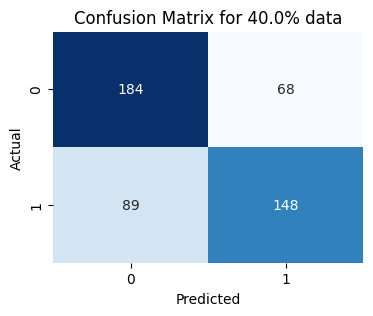

c:\Users\Akshat\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Evaluation of model trained on 60.0% data:
              precision    recall  f1-score   support

           0       0.68      0.66      0.67       252
           1       0.65      0.68      0.66       237

    accuracy                           0.67       489
   macro avg       0.67      0.67      0.67       489
weighted avg       0.67      0.67      0.67       489



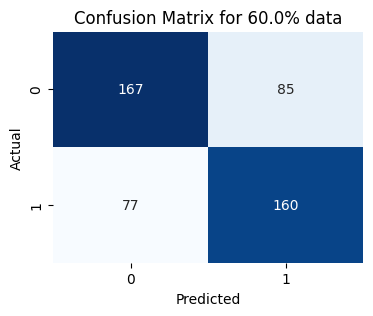

c:\Users\Akshat\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
Evaluation of model trained on 80.0% data:
              precision    recall  f1-score   support

           0       0.71      0.79      0.75       252
           1       0.74      0.66      0.70       237

    accuracy                           0.72       489
   macro avg       0.73      0.72      0.72       489
weighted avg       0.73      0.72      0.72       489



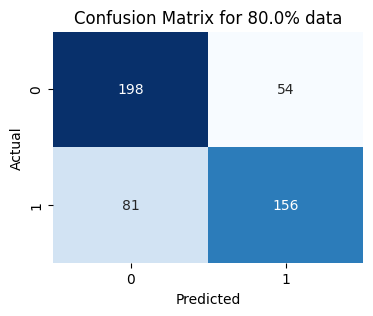

c:\Users\Akshat\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Evaluation of model trained on 100.0% data:
              precision    recall  f1-score   support

           0       0.71      0.79      0.75       252
           1       0.75      0.67      0.70       237

    accuracy                           0.73       489
   macro avg       0.73      0.73      0.73       489
weighted avg       0.73      0.73      0.73       489



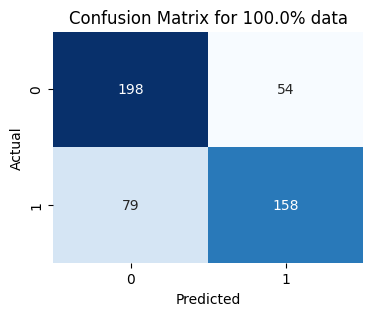

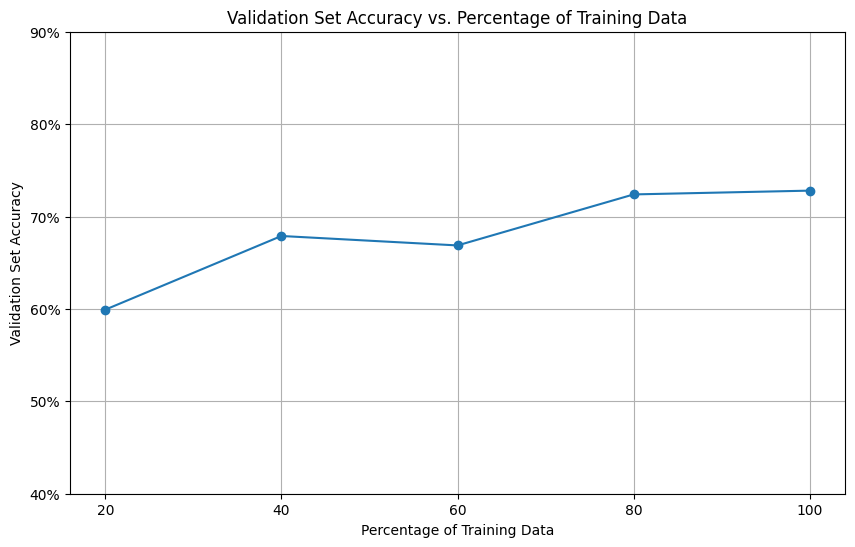


Validation Accuracy vs Percentage of Training Data:

Percentage of Training Data  Validation Accuracy
                        20%             0.599182
                        40%             0.678937
                        60%             0.668712
                        80%             0.723926
                       100%             0.728016


In [281]:
evaluate_nn_on_training_sizes(X_train, y_train, X_val, y_val, 0.010, create_lstm, epochs=75, b_s=64)

c:\Users\Akshat\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
Evaluation of model trained on 20.0% data:
              precision    recall  f1-score   support

           0       0.53      0.25      0.34       252
           1       0.49      0.76      0.60       237

    accuracy                           0.50       489
   macro avg       0.51      0.50      0.47       489
weighted avg       0.51      0.50      0.46       489



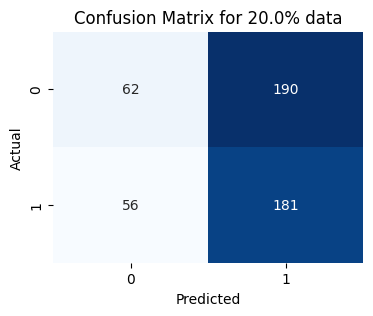

c:\Users\Akshat\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Evaluation of model trained on 40.0% data:
              precision    recall  f1-score   support

           0       0.64      0.71      0.67       252
           1       0.65      0.58      0.61       237

    accuracy                           0.64       489
   macro avg       0.64      0.64      0.64       489
weighted avg       0.64      0.64      0.64       489



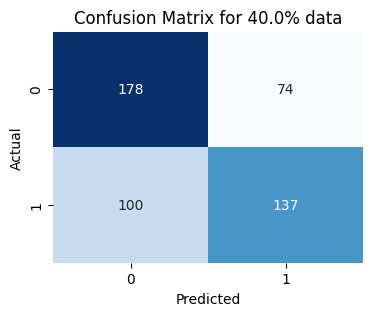

c:\Users\Akshat\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
Evaluation of model trained on 60.0% data:
              precision    recall  f1-score   support

           0       0.70      0.75      0.73       252
           1       0.72      0.66      0.69       237

    accuracy                           0.71       489
   macro avg       0.71      0.71      0.71       489
weighted avg       0.71      0.71      0.71       489



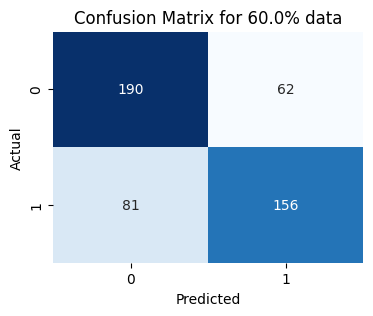

c:\Users\Akshat\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
Evaluation of model trained on 80.0% data:
              precision    recall  f1-score   support

           0       0.74      0.75      0.75       252
           1       0.73      0.73      0.73       237

    accuracy                           0.74       489
   macro avg       0.74      0.74      0.74       489
weighted avg       0.74      0.74      0.74       489



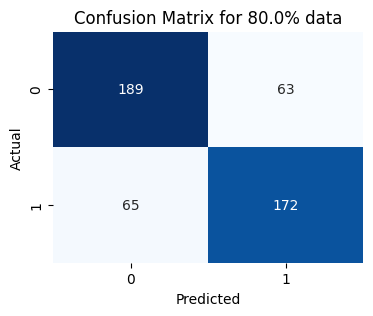

c:\Users\Akshat\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Evaluation of model trained on 100.0% data:
              precision    recall  f1-score   support

           0       0.73      0.73      0.73       252
           1       0.72      0.72      0.72       237

    accuracy                           0.73       489
   macro avg       0.73      0.73      0.73       489
weighted avg       0.73      0.73      0.73       489



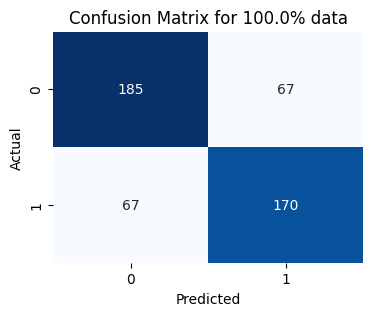

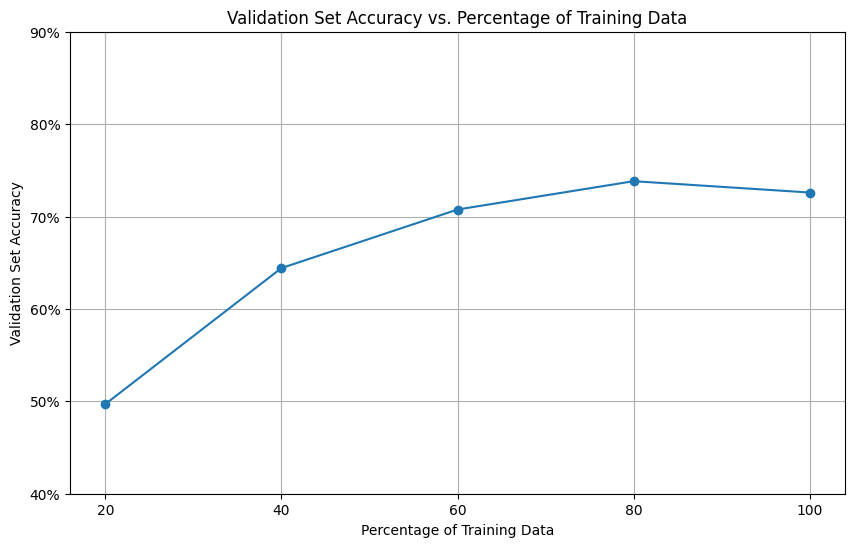


Validation Accuracy vs Percentage of Training Data:

Percentage of Training Data  Validation Accuracy
                        20%             0.496933
                        40%             0.644172
                        60%             0.707566
                        80%             0.738241
                       100%             0.725971


In [282]:
evaluate_nn_on_training_sizes(X_train, y_train, X_val, y_val, 0.010, create_lstm, epochs=75, b_s=32)

c:\Users\Akshat\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
Evaluation of model trained on 20.0% data:
              precision    recall  f1-score   support

           0       0.60      0.58      0.59       252
           1       0.57      0.59      0.58       237

    accuracy                           0.59       489
   macro avg       0.59      0.59      0.59       489
weighted avg       0.59      0.59      0.59       489



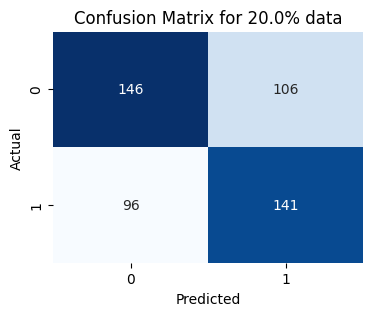

c:\Users\Akshat\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
Evaluation of model trained on 40.0% data:
              precision    recall  f1-score   support

           0       0.66      0.66      0.66       252
           1       0.64      0.64      0.64       237

    accuracy                           0.65       489
   macro avg       0.65      0.65      0.65       489
weighted avg       0.65      0.65      0.65       489



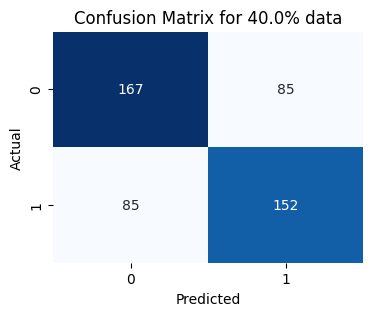

c:\Users\Akshat\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
Evaluation of model trained on 60.0% data:
              precision    recall  f1-score   support

           0       0.69      0.65      0.67       252
           1       0.65      0.69      0.67       237

    accuracy                           0.67       489
   macro avg       0.67      0.67      0.67       489
weighted avg       0.67      0.67      0.67       489



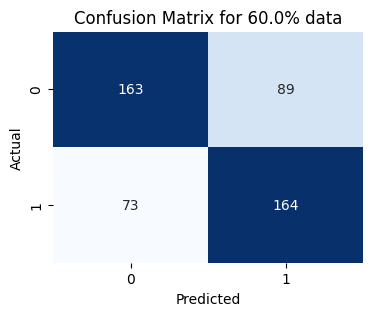

c:\Users\Akshat\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
Evaluation of model trained on 80.0% data:
              precision    recall  f1-score   support

           0       0.71      0.75      0.73       252
           1       0.72      0.68      0.70       237

    accuracy                           0.71       489
   macro avg       0.71      0.71      0.71       489
weighted avg       0.71      0.71      0.71       489



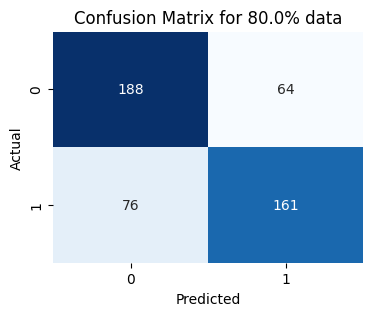

c:\Users\Akshat\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Evaluation of model trained on 100.0% data:
              precision    recall  f1-score   support

           0       0.71      0.75      0.73       252
           1       0.72      0.68      0.70       237

    accuracy                           0.72       489
   macro avg       0.72      0.71      0.71       489
weighted avg       0.72      0.72      0.72       489



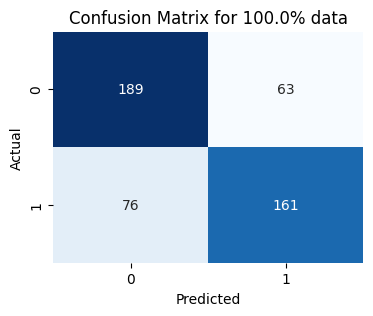

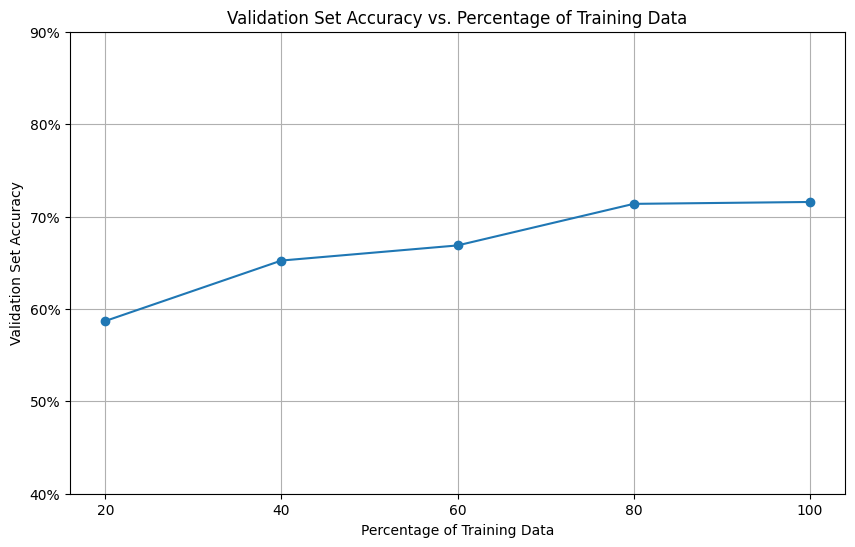


Validation Accuracy vs Percentage of Training Data:

Percentage of Training Data  Validation Accuracy
                        20%             0.586912
                        40%             0.652352
                        60%             0.668712
                        80%             0.713701
                       100%             0.715746


In [283]:
evaluate_nn_on_training_sizes(X_train, y_train, X_val, y_val, 0.010, create_lstm, epochs=75, b_s=16)

c:\Users\Akshat\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Evaluation of model trained on 20.0% data:
              precision    recall  f1-score   support

           0       0.56      0.76      0.65       252
           1       0.59      0.37      0.45       237

    accuracy                           0.57       489
   macro avg       0.58      0.56      0.55       489
weighted avg       0.58      0.57      0.55       489



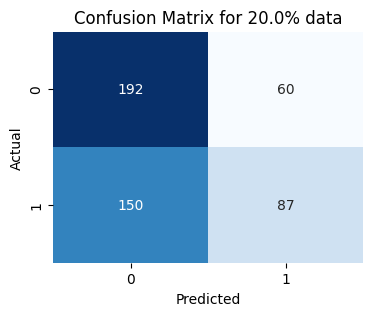

c:\Users\Akshat\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
Evaluation of model trained on 40.0% data:
              precision    recall  f1-score   support

           0       0.65      0.65      0.65       252
           1       0.63      0.62      0.63       237

    accuracy                           0.64       489
   macro avg       0.64      0.64      0.64       489
weighted avg       0.64      0.64      0.64       489



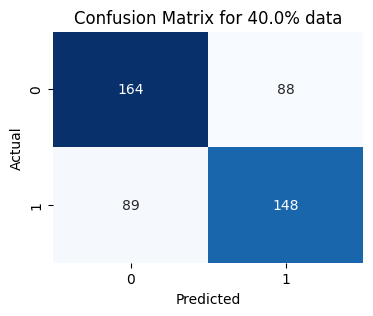

c:\Users\Akshat\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
Evaluation of model trained on 60.0% data:
              precision    recall  f1-score   support

           0       0.70      0.73      0.72       252
           1       0.70      0.67      0.68       237

    accuracy                           0.70       489
   macro avg       0.70      0.70      0.70       489
weighted avg       0.70      0.70      0.70       489



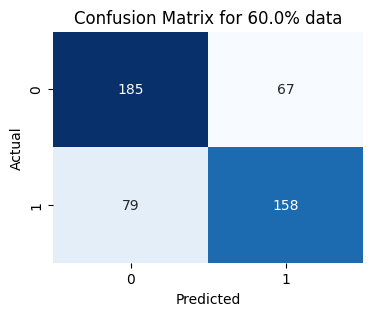

c:\Users\Akshat\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
Evaluation of model trained on 80.0% data:
              precision    recall  f1-score   support

           0       0.72      0.71      0.72       252
           1       0.70      0.71      0.71       237

    accuracy                           0.71       489
   macro avg       0.71      0.71      0.71       489
weighted avg       0.71      0.71      0.71       489



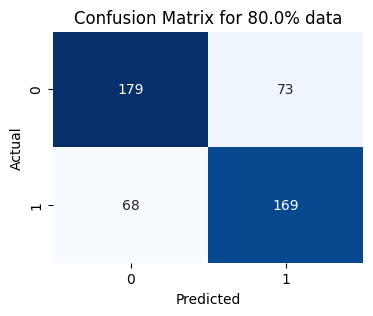

c:\Users\Akshat\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
Evaluation of model trained on 100.0% data:
              precision    recall  f1-score   support

           0       0.74      0.79      0.76       252
           1       0.76      0.70      0.73       237

    accuracy                           0.75       489
   macro avg       0.75      0.75      0.75       489
weighted avg       0.75      0.75      0.75       489



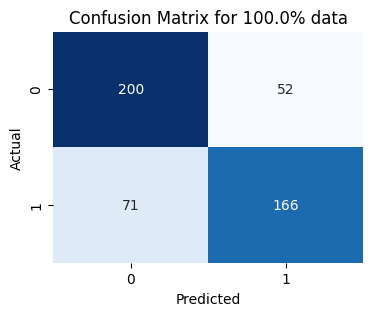

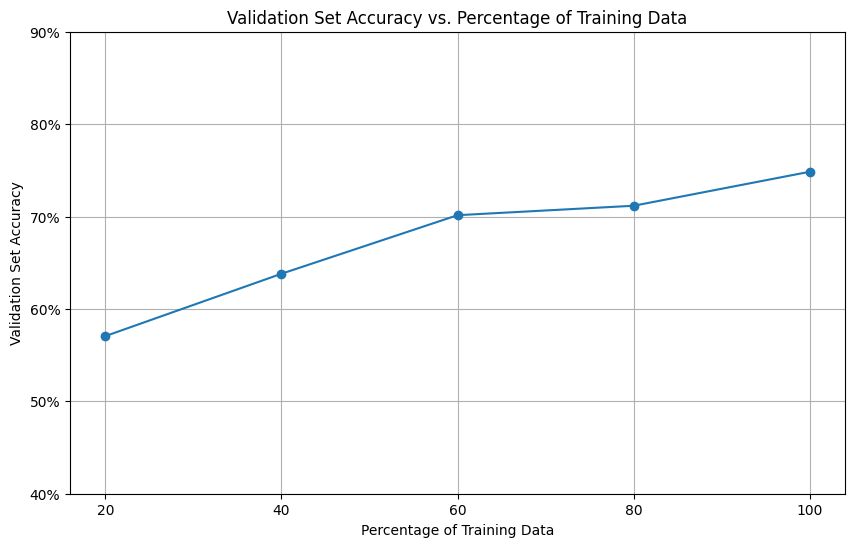


Validation Accuracy vs Percentage of Training Data:

Percentage of Training Data  Validation Accuracy
                        20%             0.570552
                        40%             0.638037
                        60%             0.701431
                        80%             0.711656
                       100%             0.748466


In [284]:
evaluate_nn_on_training_sizes(X_train, y_train, X_val, y_val, 0.010, create_lstm, epochs=75, b_s=256)

**Bidirectional LSTM**

In [170]:
vocab_size = 10
embedding_dim = 32
max_sequence_length = 50

def create_bi_lstm():
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length))
    model.add(Bidirectional(LSTM(16)))
    model.add(Dense(1, activation='sigmoid'))
    return model

# Reshape the input data to be 3D [samples, timesteps, features]
X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val_reshaped = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Evaluation of model trained on 20.0% data:
              precision    recall  f1-score   support

           0       0.59      0.58      0.59       252
           1       0.56      0.57      0.56       237

    accuracy                           0.57       489
   macro avg       0.57      0.57      0.57       489
weighted avg       0.57      0.57      0.57       489



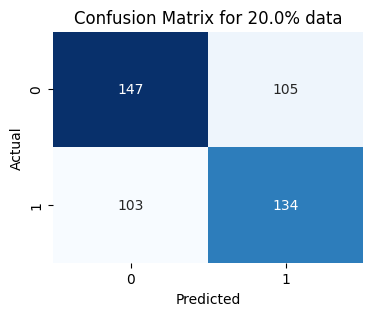

c:\Users\Akshat\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Evaluation of model trained on 40.0% data:
              precision    recall  f1-score   support

           0       0.57      0.59      0.58       252
           1       0.54      0.52      0.53       237

    accuracy                           0.56       489
   macro avg       0.56      0.56      0.56       489
weighted avg       0.56      0.56      0.56       489



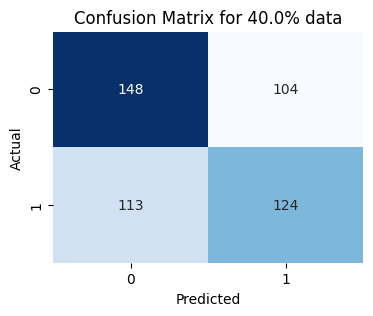

c:\Users\Akshat\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
Evaluation of model trained on 60.0% data:
              precision    recall  f1-score   support

           0       0.64      0.55      0.59       252
           1       0.58      0.67      0.62       237

    accuracy                           0.61       489
   macro avg       0.61      0.61      0.61       489
weighted avg       0.61      0.61      0.61       489



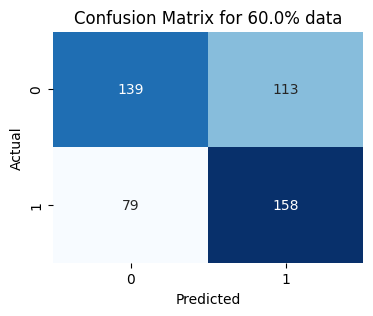

c:\Users\Akshat\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
Evaluation of model trained on 80.0% data:
              precision    recall  f1-score   support

           0       0.60      0.58      0.59       252
           1       0.57      0.59      0.58       237

    accuracy                           0.58       489
   macro avg       0.58      0.58      0.58       489
weighted avg       0.59      0.58      0.58       489



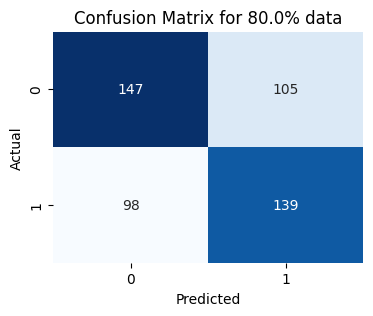

c:\Users\Akshat\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Evaluation of model trained on 100.0% data:
              precision    recall  f1-score   support

           0       0.57      0.52      0.55       252
           1       0.53      0.58      0.56       237

    accuracy                           0.55       489
   macro avg       0.55      0.55      0.55       489
weighted avg       0.55      0.55      0.55       489



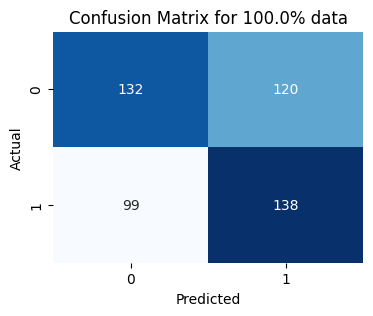

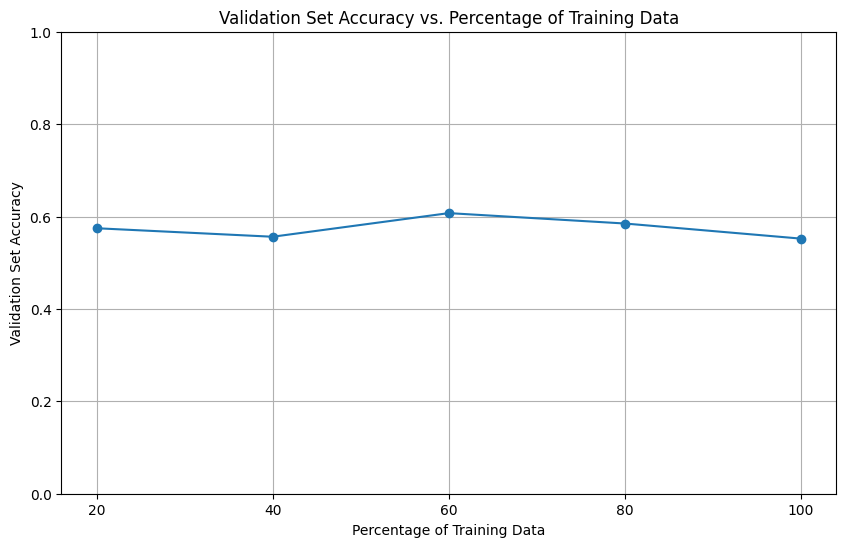


Validation Accuracy vs Percentage of Training Data:

Percentage of Training Data  Validation Accuracy
                        20%             0.574642
                        40%             0.556237
                        60%             0.607362
                        80%             0.584867
                       100%             0.552147


In [147]:
evaluate_nn_on_training_sizes(X_train, y_train, X_val, y_val, 0.01, create_bi_lstm, epochs=75)